# Linear models  

In this notebook we will be looking at ways to use linear models to predict electricity demand for the GTA. We will try different combinations of features through best subset selection which in the end should give us a sense of the most important features. We will also use regularization and combining dimensionality reduction with linear regression to see if either can do better than best subset selection. Finally, we will ensemble our best linear model with the ARIMA time series model.

In [1]:
# Only necessary if running in colab
# You may need to restart your runtime
running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
  !pip install git+https://github.com/statsmodels/statsmodels
  !pip install Cython
  !pip install git+git://github.com/scikit-learn/scikit-learn.git
  !pip install git+https://github.com/mwaskom/seaborn.git

In [2]:
import itertools
import math
import warnings
import os

import seaborn as sns
import torch # Only used for autoencoders
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA

# In case you are running this in colab
# And this to make it download
if running_in_colab:
  from google.colab import files 

In [3]:
# We create an output directory for all of the results produced from this notebook
# This line of code is taken from a discussion with Soroush Saryazdi (TA)
path = 'output_linear_models'
if not os.path.exists(path):
 os.mkdir(path)

## Data preparation
We will use data from 2012 to 2016 to train and tune (via cross validation), our models. As in the time series notebook, we will be using 10-fold cross validation for all models as this faithfully reflects the test set performance measure we will be using. A reminder that we will quantify the performance of our model by its RMSE on an unseen half a year period of time. Since we have 5 years of training and 10 folds, each validation fold has approximately half a year of data to validate.

Once we pick the optimal model, we will retrain it on 2012-2016 and plot its prediction for the first half of 2017 to understand its behaviour and compare it with previous models.

In [4]:
# Load the data
# This is the data set AFTER outliers have been handled
data = pd.read_csv("MergedDataset.csv", delimiter = ",", index_col=0)
data

,Date,Hour,Datetime,Toronto,HOEP,temperature,precipitation,snowfall,snow_mass,air_density,radiation_surface,radiation_toa,cloud_cover,isWeekend,isHoliday
0,2004-01-01,00:00:00.000000000,2004-01-01 00:00:00,4606,30.90,0.198,0.001,0.000,1.156,1.279,0.0,0.0,0.118,0,1
1,2004-01-01,01:00:00.000000000,2004-01-01 01:00:00,4366,27.13,0.339,0.001,0.000,1.156,1.279,0.0,0.0,0.148,0,1
2,2004-01-01,02:00:00.000000000,2004-01-01 02:00:00,4188,25.23,0.502,0.001,0.001,1.156,1.280,0.0,0.0,0.144,0,1
3,2004-01-01,03:00:00.000000000,2004-01-01 03:00:00,4046,24.29,0.534,0.000,0.000,1.157,1.280,0.0,0.0,0.159,0,1
4,2004-01-01,04:00:00.000000000,2004-01-01 04:00:00,3974,24.42,0.494,0.000,0.000,1.157,1.281,0.0,0.0,0.194,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131491,2018-12-31,19:00:00.000000000,2018-12-31 19:00:00,5755,5.62,2.908,2.279,0.566,3.426,1.243,0.0,0.0,0.988,0,0
131492,2018-12-31,20:00:00.000000000,2018-12-31 20:00:00,5544,8.95,2.383,1.402,0.263,3.773,1.242,0.0,0.0,0.981,0,0
131493,2018-12-31,21:00:00.000000000,2018-12-31 21:00:00,5338,5.81,2.611,0.244,0.041,3.866,1.237,0.0,0.0,0.985,0,0
131494,2018-12-31,22:00:00.000000000,2018-12-31 22:00:00,5091,2.87,3.384,0.283,0.076,3.872,1.227,0.0,0.0,0.990,0,0


In [5]:
# Checking the types of each column of our loaded data.
data.dtypes

Date                  object
Hour                  object
Datetime              object
Toronto                int64
HOEP                 float64
temperature          float64
precipitation        float64
snowfall             float64
snow_mass            float64
air_density          float64
radiation_surface    float64
radiation_toa        float64
cloud_cover          float64
isWeekend              int64
isHoliday              int64
dtype: object

In [6]:
# Converting the 'Datetime' column from object to datetime.
data['Datetime'] = pd.to_datetime(data['Datetime'])

In [7]:
# Convertin 'isWeekend' and 'isHoliday' to categorical data
data['isWeekend'] = data['isWeekend'].astype('category')
data['isHoliday'] = data['isHoliday'].astype('category')

In [8]:
# Checking that our 'Datetime' column got converted to the right type
data.dtypes

Date                         object
Hour                         object
Datetime             datetime64[ns]
Toronto                       int64
HOEP                        float64
temperature                 float64
precipitation               float64
snowfall                    float64
snow_mass                   float64
air_density                 float64
radiation_surface           float64
radiation_toa               float64
cloud_cover                 float64
isWeekend                  category
isHoliday                  category
dtype: object

In [9]:
# Updating whole data set to start from 2012 and end at 2017
data = data[data['Datetime'].dt.year >= 2012]
data = data[data['Datetime'].dt.year < 2018]
data = data.reset_index(drop=True)
data

,Date,Hour,Datetime,Toronto,HOEP,temperature,precipitation,snowfall,snow_mass,air_density,radiation_surface,radiation_toa,cloud_cover,isWeekend,isHoliday
0,2012-01-01,00:00:00.000000000,2012-01-01 00:00:00,4834,21.71,0.672,0.032,0.004,6.048,1.267,0.0,0.0,0.538,1,1
1,2012-01-01,01:00:00.000000000,2012-01-01 01:00:00,4631,16.92,0.932,0.004,0.002,6.054,1.265,0.0,0.0,0.581,1,1
2,2012-01-01,02:00:00.000000000,2012-01-01 02:00:00,4442,11.23,1.319,0.006,0.004,6.059,1.262,0.0,0.0,0.676,1,1
3,2012-01-01,03:00:00.000000000,2012-01-01 03:00:00,4312,7.10,1.715,0.008,0.004,6.066,1.259,0.0,0.0,0.624,1,1
4,2012-01-01,04:00:00.000000000,2012-01-01 04:00:00,4224,-6.70,2.019,0.013,0.003,6.070,1.256,0.0,0.0,0.637,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52603,2017-12-31,19:00:00.000000000,2017-12-31 19:00:00,6303,40.04,-13.263,0.004,0.004,16.693,1.358,0.0,0.0,0.355,1,0
52604,2017-12-31,20:00:00.000000000,2017-12-31 20:00:00,6124,39.71,-13.505,0.004,0.004,16.699,1.359,0.0,0.0,0.398,1,0
52605,2017-12-31,21:00:00.000000000,2017-12-31 21:00:00,5904,39.37,-13.618,0.004,0.004,16.705,1.359,0.0,0.0,0.439,1,0
52606,2017-12-31,22:00:00.000000000,2017-12-31 22:00:00,5674,39.79,-13.762,0.005,0.005,16.710,1.359,0.0,0.0,0.440,1,0


In [10]:
# Create a new column 't' which is just the index of each date starting at 0
data.insert(0, 't', np.arange(len(data))) 

# Checking that the new column gets created and that it does what it's expected to
data

,t,Date,Hour,Datetime,Toronto,HOEP,temperature,precipitation,snowfall,snow_mass,air_density,radiation_surface,radiation_toa,cloud_cover,isWeekend,isHoliday
0,0,2012-01-01,00:00:00.000000000,2012-01-01 00:00:00,4834,21.71,0.672,0.032,0.004,6.048,1.267,0.0,0.0,0.538,1,1
1,1,2012-01-01,01:00:00.000000000,2012-01-01 01:00:00,4631,16.92,0.932,0.004,0.002,6.054,1.265,0.0,0.0,0.581,1,1
2,2,2012-01-01,02:00:00.000000000,2012-01-01 02:00:00,4442,11.23,1.319,0.006,0.004,6.059,1.262,0.0,0.0,0.676,1,1
3,3,2012-01-01,03:00:00.000000000,2012-01-01 03:00:00,4312,7.10,1.715,0.008,0.004,6.066,1.259,0.0,0.0,0.624,1,1
4,4,2012-01-01,04:00:00.000000000,2012-01-01 04:00:00,4224,-6.70,2.019,0.013,0.003,6.070,1.256,0.0,0.0,0.637,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52603,52603,2017-12-31,19:00:00.000000000,2017-12-31 19:00:00,6303,40.04,-13.263,0.004,0.004,16.693,1.358,0.0,0.0,0.355,1,0
52604,52604,2017-12-31,20:00:00.000000000,2017-12-31 20:00:00,6124,39.71,-13.505,0.004,0.004,16.699,1.359,0.0,0.0,0.398,1,0
52605,52605,2017-12-31,21:00:00.000000000,2017-12-31 21:00:00,5904,39.37,-13.618,0.004,0.004,16.705,1.359,0.0,0.0,0.439,1,0
52606,52606,2017-12-31,22:00:00.000000000,2017-12-31 22:00:00,5674,39.79,-13.762,0.005,0.005,16.710,1.359,0.0,0.0,0.440,1,0


In [11]:
# Get the index where the validation set begins (will use later)
train_val_split = data[data['Datetime'] == '2017-01-01 00:00:00'].index[0]
train_val_split

43848

In [12]:
# Creating our train set 2012 to 2016 inclusive
data_train = data[data['Datetime'].dt.year < 2017]
data_train

,t,Date,Hour,Datetime,Toronto,HOEP,temperature,precipitation,snowfall,snow_mass,air_density,radiation_surface,radiation_toa,cloud_cover,isWeekend,isHoliday
0,0,2012-01-01,00:00:00.000000000,2012-01-01 00:00:00,4834,21.71,0.672,0.032,0.004,6.048,1.267,0.0,0.0,0.538,1,1
1,1,2012-01-01,01:00:00.000000000,2012-01-01 01:00:00,4631,16.92,0.932,0.004,0.002,6.054,1.265,0.0,0.0,0.581,1,1
2,2,2012-01-01,02:00:00.000000000,2012-01-01 02:00:00,4442,11.23,1.319,0.006,0.004,6.059,1.262,0.0,0.0,0.676,1,1
3,3,2012-01-01,03:00:00.000000000,2012-01-01 03:00:00,4312,7.10,1.715,0.008,0.004,6.066,1.259,0.0,0.0,0.624,1,1
4,4,2012-01-01,04:00:00.000000000,2012-01-01 04:00:00,4224,-6.70,2.019,0.013,0.003,6.070,1.256,0.0,0.0,0.637,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43843,43843,2016-12-31,19:00:00.000000000,2016-12-31 19:00:00,5665,2.81,2.506,0.140,0.014,4.203,1.243,0.0,0.0,0.875,1,0
43844,43844,2016-12-31,20:00:00.000000000,2016-12-31 20:00:00,5665,0.00,2.218,0.043,0.002,4.131,1.245,0.0,0.0,0.579,1,0
43845,43845,2016-12-31,21:00:00.000000000,2016-12-31 21:00:00,5665,0.00,1.579,0.017,0.005,4.099,1.250,0.0,0.0,0.188,1,0
43846,43846,2016-12-31,22:00:00.000000000,2016-12-31 22:00:00,5665,0.00,0.515,0.007,0.003,4.101,1.258,0.0,0.0,0.172,1,0


## Fourier regression

To account for the seasonality in the data it will not be enough to consider a linear model of the form $X_t = \beta_1 t + \beta_0$ as this would only pickup on the underlying linear trend in the data (for which we already showed in the time series analysis is).

We need to introduce some seasonal behaviour in our linear model. One way to do this  is through fourier feature bases [source here](https://otexts.com/fpp2/useful-predictors.html). If $m$ is the seasonal period we suspect (e.g. daily, weekly, yearly) then we can introduce terms of the following form:
$X_t = \sum_{j=1}^P \beta_{2j-1} \sin(\frac{2 \pi j t}{m}) + \beta_{2j} \cos(\frac{2 \pi j t}{m})$ <br>
where $X_t$ is the electricity demand at time $t$, $m$ is the the seasonal period and $P$ is the number of pairs of fourier series we have. 

We will bound $P$ to at most $\frac{m}{2}$. For daily seasonality $m=24$, for weekly $m=7 \times 24 = 168$ and yearly as $365 \times 24 = 8760$. We use $P_d, P_w, P_y$ to represent the number of Fourier bases to use for daily, weekly and yearly seasonality respectively (we exclude monthly as this will just be the weekly seasonality observed roughly 4 times). In this case our model will have the following structure:<br>
$X_t = \beta_0 + \sum_{j=1}^{P_d} \beta_{2j-1} \Big{(}\sin(\frac{2 \pi j t}{m_d}) + \beta_{2j} \cos(\frac{2 \pi j t}{m_d}) \Big{)}+ \sum_{k=1}^{P_w} \Big{(} \beta_{2k-1} \sin(\frac{2 \pi k t}{m_w}) + \beta_{2k} \cos(\frac{2 \pi k t}{m_w}) \Big{)} + \sum_{l=1}^{P_y} \Big{(} \beta_{2l-1} \sin(\frac{2 \pi l t}{m_y}) + \beta_{2l} \cos(\frac{2 \pi l t}{m_y}) \Big{)}$  <br>
where $m_d, m_w, m_y = 24, 7\times 24, 365 \times 24$ respectively and $P_d, P_w, P_y$ can go up to $\frac{m_d}{2} - 1, \frac{m_w}{2} - 1, \frac{m_y}{2} - 1$ respectively. We will create feature transformations and find the optimal $P_d, P_w, P_y$. 



In [13]:
# Starting our design matrix (essentially adding 't' from data_train)
# We apply this to the whole data since we will need to use the feature basis
# for the plotting of the validation set as well.
design_matrix = np.array(data['t']).reshape(-1,1)

In [14]:
# 1. Fourier feature bases for Daily seasonal period
m_day = 24
P_day = int(m_day/2)
j_day = np.arange(1, int(P_day))

# Generating the column names we need for the dataframe
titles_sin, titles_cos = ['daily_sin_' + str(x) for x in j_day], ['daily_cos_' + str(x) for x in j_day]

# Generating the number to which we will apply sin and cos afterwards
temp_multiply = (2 * np.pi * j_day)/m_day

# Generating the sin and cos values
daily_design_matrix_sin = pd.DataFrame(data = np.sin(temp_multiply * design_matrix), columns = titles_sin, dtype = np.float32)
daily_design_matrix_cos = pd.DataFrame(data = np.cos(temp_multiply * design_matrix), columns = titles_cos, dtype = np.float32)

# Merging the two dataframes to be a single dataframe
daily_design_matrix =  pd.concat([daily_design_matrix_sin, daily_design_matrix_cos], axis = 1)

# Reordering the columns in a more convenient way (sin and cos tuples with incrementing index j)
titles_daily = list(sum(zip(titles_sin, titles_cos), ()))
daily_design_matrix = daily_design_matrix[titles_daily]

In [15]:
# Get index for the day start which will be useful for hyperparameter search later
start_day = 0

# Printing weekly design matrix
daily_design_matrix

,daily_sin_1,daily_cos_1,daily_sin_2,daily_cos_2,daily_sin_3,daily_cos_3,daily_sin_4,daily_cos_4,daily_sin_5,daily_cos_5,daily_sin_6,daily_cos_6,daily_sin_7,daily_cos_7,daily_sin_8,daily_cos_8,daily_sin_9,daily_cos_9,daily_sin_10,daily_cos_10,daily_sin_11,daily_cos_11
0,0.000000,1.000000,0.000000,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.0,0.000000,1.000000,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000e+00,1.0,0.000000e+00,1.000000e+00,0.000000,1.000000e+00,0.000000,1.000000
1,0.258819,0.965926,0.500000,8.660254e-01,7.071068e-01,7.071068e-01,8.660254e-01,0.5,0.965926,0.258819,1.000000e+00,6.123234e-17,0.965926,-0.258819,8.660254e-01,-0.5,7.071068e-01,-7.071068e-01,0.500000,-8.660254e-01,0.258819,-0.965926
2,0.500000,0.866025,0.866025,5.000000e-01,1.000000e+00,6.123234e-17,8.660254e-01,-0.5,0.500000,-0.866025,1.224647e-16,-1.000000e+00,-0.500000,-0.866025,-8.660254e-01,-0.5,-1.000000e+00,-1.836970e-16,-0.866025,5.000000e-01,-0.500000,0.866025
3,0.707107,0.707107,1.000000,6.123234e-17,7.071068e-01,-7.071068e-01,1.224647e-16,-1.0,-0.707107,-0.707107,-1.000000e+00,-1.836970e-16,-0.707107,0.707107,-2.449294e-16,1.0,7.071068e-01,7.071068e-01,1.000000,3.061617e-16,0.707107,-0.707107
4,0.866025,0.500000,0.866025,-5.000000e-01,1.224647e-16,-1.000000e+00,-8.660254e-01,-0.5,-0.866025,0.500000,-2.449294e-16,1.000000e+00,0.866025,0.500000,8.660254e-01,-0.5,3.673940e-16,-1.000000e+00,-0.866025,-5.000000e-01,-0.866025,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52603,-0.965926,0.258819,-0.500000,-8.660254e-01,7.071068e-01,-7.071068e-01,8.660254e-01,0.5,-0.258819,0.965926,-1.000000e+00,-1.545900e-12,-0.258819,-0.965926,8.660254e-01,-0.5,7.071068e-01,7.071068e-01,-0.500000,8.660254e-01,-0.965926,-0.258819
52604,-0.866025,0.500000,-0.866025,-5.000000e-01,2.054622e-12,-1.000000e+00,8.660254e-01,-0.5,0.866025,0.500000,-4.109245e-12,1.000000e+00,-0.866025,0.500000,-8.660254e-01,-0.5,6.163867e-12,-1.000000e+00,0.866025,-5.000000e-01,0.866025,0.500000
52605,-0.707107,0.707107,-1.000000,-4.649516e-12,-7.071068e-01,-7.071068e-01,9.299031e-12,-1.0,0.707107,-0.707107,1.000000e+00,6.672589e-12,0.707107,0.707107,-1.859806e-11,1.0,-7.071068e-01,7.071068e-01,-1.000000,-1.419704e-12,-0.707107,-0.707107
52606,-0.500000,0.866025,-0.866025,5.000000e-01,-1.000000e+00,-4.617966e-12,-8.660254e-01,-0.5,-0.500000,-0.866025,9.235932e-12,-1.000000e+00,0.500000,-0.866025,8.660254e-01,-0.5,1.000000e+00,-6.980161e-13,0.866025,5.000000e-01,0.500000,0.866025


In [16]:
# 2. Fourier feature bases for Weekly seasonal period
m_week = 24 * 7
P_week = int(m_week/2)
j_week = np.array([i for i in range(1, int(P_week)) if i/m_week not in j_day/m_day])# We make sure to remove duplicate columns

# Generating the column names we need for the dataframe
titles_sin, titles_cos = ['weekly_sin_' + str(x) for x in j_week], ['weekly_cos_' + str(x) for x in j_week]

# Generating the number to which we will apply sin and cos afterwards
temp_multiply = (2 * np.pi * j_week)/m_week

# Generating the sin and cos values
weekly_design_matrix_sin = pd.DataFrame(data = np.sin(temp_multiply * design_matrix), columns = titles_sin, dtype = np.float32)
weekly_design_matrix_cos = pd.DataFrame(data = np.cos(temp_multiply * design_matrix), columns = titles_cos, dtype = np.float32)

# Merging the two dataframes to be a single dataframe
weekly_design_matrix =  pd.concat([weekly_design_matrix_sin, weekly_design_matrix_cos], axis = 1)

# Reordering the columns in a more convenient way (sin and cos tuples with a specific index j)
titles_weekly = list(sum(zip(titles_sin, titles_cos), ()))
weekly_design_matrix = weekly_design_matrix[titles_weekly]

In [17]:
# Get index for the week start which will be useful for hyperparameter later
start_week = start_day + len(daily_design_matrix.columns)

# Printing weekly design matrix
weekly_design_matrix

,weekly_sin_1,weekly_cos_1,weekly_sin_2,weekly_cos_2,weekly_sin_3,weekly_cos_3,weekly_sin_4,weekly_cos_4,weekly_sin_5,weekly_cos_5,weekly_sin_6,weekly_cos_6,weekly_sin_8,weekly_cos_8,weekly_sin_9,weekly_cos_9,weekly_sin_10,weekly_cos_10,weekly_sin_11,weekly_cos_11,weekly_sin_12,weekly_cos_12,weekly_sin_13,weekly_cos_13,weekly_sin_15,weekly_cos_15,weekly_sin_16,weekly_cos_16,weekly_sin_17,weekly_cos_17,weekly_sin_18,weekly_cos_18,weekly_sin_19,weekly_cos_19,weekly_sin_20,weekly_cos_20,weekly_sin_22,weekly_cos_22,weekly_sin_23,weekly_cos_23,...,weekly_sin_61,weekly_cos_61,weekly_sin_62,weekly_cos_62,weekly_sin_64,weekly_cos_64,weekly_sin_65,weekly_cos_65,weekly_sin_66,weekly_cos_66,weekly_sin_67,weekly_cos_67,weekly_sin_68,weekly_cos_68,weekly_sin_69,weekly_cos_69,weekly_sin_71,weekly_cos_71,weekly_sin_72,weekly_cos_72,weekly_sin_73,weekly_cos_73,weekly_sin_74,weekly_cos_74,weekly_sin_75,weekly_cos_75,weekly_sin_76,weekly_cos_76,weekly_sin_78,weekly_cos_78,weekly_sin_79,weekly_cos_79,weekly_sin_80,weekly_cos_80,weekly_sin_81,weekly_cos_81,weekly_sin_82,weekly_cos_82,weekly_sin_83,weekly_cos_83
0,0.000000,1.000000,0.000000,1.000000e+00,0.000000,1.000000,0.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000e+00,0.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000e+00,0.000000,1.000000,0.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000e+00,0.000000,1.000000,0.000000e+00,1.000000,0.000000,1.000000e+00,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000e+00,0.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000e+00,0.000000,1.000000,0.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000e+00,0.000000,1.000000,0.000000e+00,1.000000,0.000000,1.000000e+00,0.000000,1.000000,0.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000e+00,0.000000,1.000000
1,0.037391,0.999301,0.074730,9.972038e-01,0.111964,0.993712,1.490423e-01,0.988831,0.185912,0.982566,0.222521,9.749279e-01,2.947552e-01,0.955573,0.330279,0.943883,0.365341,9.308738e-01,0.399892,0.916562,4.338837e-01,0.900969,0.467269,0.884115,0.532032,0.846724,5.633200e-01,0.826239,0.593820,0.804598,0.623490,7.818315e-01,0.652287,0.757972,6.801727e-01,0.733052,0.733052,6.801727e-01,0.757972,0.652287,...,0.757972,-0.652287,0.733052,-6.801727e-01,6.801727e-01,-0.733052,0.652287,-0.757972,0.623490,-7.818315e-01,0.593820,-0.804598,5.633200e-01,-0.826239,0.532032,-0.846724,0.467269,-0.884115,4.338837e-01,-0.900969,0.399892,-0.916562,0.365341,-9.308738e-01,0.330279,-0.943883,2.947552e-01,-0.955573,0.222521,-9.749279e-01,0.185912,-0.982566,1.490423e-01,-0.988831,0.111964,-0.993712,0.074730,-9.972038e-01,0.037391,-0.999301
2,0.074730,0.997204,0.149042,9.888308e-01,0.222521,0.974928,2.947552e-01,0.955573,0.365341,0.930874,0.433884,9.009688e-01,5.633200e-01,0.826239,0.623490,0.781832,0.680173,7.330519e-01,0.733052,0.680173,7.818315e-01,0.623490,0.826239,0.563320,0.900969,0.433884,9.308738e-01,0.365341,0.955573,0.294755,0.974928,2.225209e-01,0.988831,0.149042,9.972038e-01,0.074730,0.997204,-7.473009e-02,0.988831,-0.149042,...,-0.988831,-0.149042,-0.997204,-7.473009e-02,-9.972038e-01,0.074730,-0.988831,0.149042,-0.974928,2.225209e-01,-0.955573,0.294755,-9.308738e-01,0.365341,-0.900969,0.433884,-0.826239,0.563320,-7.818315e-01,0.623490,-0.733052,0.680173,-0.680173,7.330519e-01,-0.623490,0.781832,-5.633200e-01,0.826239,-0.433884,9.009688e-01,-0.365341,0.930874,-2.947552e-01,0.955573,-0.222521,0.974928,-0.149042,9.888308e-01,-0.074730,0.997204
3,0.111964,0.993712,0.222521,9.749279e-01,0.330279,0.943883,4.338837e-01,0.900969,0.532032,0.846724,0.623490,7.818315e-01,7.818315e-01,0.623490,0.846724,0.532032,0.900969,4.338837e-01,0.943883,0.330279,9.749279e-01,0.222521,0.993712,0.111964,0.993712,-0.111964,9.749279e-01,-0.222521,0.943883,-0.330279,0.900969,-4.338837e-01,0.846724,-0.532032,7.818315e-01,-0.623490,0.623490,-7.818315e-01,0.532032,-0.846724,...,0.532032,0.8467

In [18]:
# 3. Fourier feature bases for Yearly seasonal period
m_year = 24 * 365
P_year = int(m_year/2)
j_year = np.array([i for i in range(1, int(P_year)) if i/m_year not in j_day/m_day and i/m_year not in j_week/m_week]) # Remove duplicate columns

# Generating the column names we need for the dataframe
titles_sin, titles_cos = ['yearly_sin_' + str(x) for x in j_year], ['yearly_cos_' + str(x) for x in j_year]

# Generating the number to which we will apply sin and cos afterwards
temp_multiply = (2 * np.pi * j_year)/m_year

# Generating the sin and cos values
yearly_design_matrix_sin = pd.DataFrame(data = np.sin(temp_multiply * design_matrix), columns = titles_sin, dtype = np.float32)
yearly_design_matrix_cos = pd.DataFrame(data = np.cos(temp_multiply * design_matrix), columns = titles_cos, dtype = np.float32)

# Merging the two dataframes to be a single dataframe
yearly_design_matrix =  pd.concat([yearly_design_matrix_sin, yearly_design_matrix_cos], axis = 1)

# Reordering the columns in a more convenient way (sin and cos tuples with a specific index j)
titles_yearly = list(sum(zip(titles_sin, titles_cos), ()))
yearly_design_matrix = yearly_design_matrix[titles_yearly]
# This extra matrix will be the restricted search space, we hardcoded
# the choice of the first 730 columns as this seemed like more than
# enough for training and prevented memory overflow.
yearly_design_matrix_no_overflow = yearly_design_matrix.iloc[:, 0:(730*2)]

In [19]:
# Get index for the year start which will be useful for hyperparameter later
start_year = start_week + len(weekly_design_matrix.columns)

# Printing yearly design matrix
yearly_design_matrix

,yearly_sin_1,yearly_cos_1,yearly_sin_2,yearly_cos_2,yearly_sin_3,yearly_cos_3,yearly_sin_4,yearly_cos_4,yearly_sin_5,yearly_cos_5,yearly_sin_6,yearly_cos_6,yearly_sin_7,yearly_cos_7,yearly_sin_8,yearly_cos_8,yearly_sin_9,yearly_cos_9,yearly_sin_10,yearly_cos_10,yearly_sin_11,yearly_cos_11,yearly_sin_12,yearly_cos_12,yearly_sin_13,yearly_cos_13,yearly_sin_14,yearly_cos_14,yearly_sin_15,yearly_cos_15,yearly_sin_16,yearly_cos_16,yearly_sin_17,yearly_cos_17,yearly_sin_18,yearly_cos_18,yearly_sin_19,yearly_cos_19,yearly_sin_20,yearly_cos_20,...,yearly_sin_4360,yearly_cos_4360,yearly_sin_4361,yearly_cos_4361,yearly_sin_4362,yearly_cos_4362,yearly_sin_4363,yearly_cos_4363,yearly_sin_4364,yearly_cos_4364,yearly_sin_4365,yearly_cos_4365,yearly_sin_4366,yearly_cos_4366,yearly_sin_4367,yearly_cos_4367,yearly_sin_4368,yearly_cos_4368,yearly_sin_4369,yearly_cos_4369,yearly_sin_4370,yearly_cos_4370,yearly_sin_4371,yearly_cos_4371,yearly_sin_4372,yearly_cos_4372,yearly_sin_4373,yearly_cos_4373,yearly_sin_4374,yearly_cos_4374,yearly_sin_4375,yearly_cos_4375,yearly_sin_4376,yearly_cos_4376,yearly_sin_4377,yearly_cos_4377,yearly_sin_4378,yearly_cos_4378,yearly_sin_4379,yearly_cos_4379
0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.000717,1.000000,0.001435,0.999999,0.002152,0.999998,0.002869,0.999996,0.003586,0.999994,0.004304,0.999991,0.005021,0.999987,0.005738,0.999984,0.006455,0.999979,0.007173,0.999974,0.007890,0.999969,0.008607,0.999963,0.009324,0.999957,0.010041,0.999950,0.010759,0.999942,0.011476,0.999934,0.012193,0.999926,0.012910,0.999917,0.013627,0.999907,0.014345,0.999897,...,0.014345,-0.999897,0.013627,-0.999907,0.012910,-0.999917,0.012193,-0.999926,0.011476,-0.999934,0.010759,-0.999942,0.010041,-0.999950,0.009324,-0.999957,0.008607,-0.999963,0.007890,-0.999969,0.007173,-0.999974,0.006455,-0.999979,0.005738,-0.999984,0.005021,-0.999987,0.004304,-0.999991,0.003586,-0.999994,0.002869,-0.999996,0.002152,-0.999998,0.001435,-0.999999,0.000717,-1.000000
2,0.001435,0.999999,0.002869,0.999996,0.004304,0.999991,0.005738,0.999984,0.007173,0.999974,0.008607,0.999963,0.010041,0.999950,0.011476,0.999934,0.012910,0.999917,0.014345,0.999897,0.015779,0.999875,0.017213,0.999852,0.018648,0.999826,0.020082,0.999798,0.021516,0.999768,0.022950,0.999737,0.024384,0.999703,0.025818,0.999667,0.027252,0.999629,0.028686,0.999588,...,-0.028686,0.999588,-0.027252,0.999629,-0.025818,0.999667,-0.024384,0.999703,-0.022950,0.999737,-0.021516,0.999768,-0.020082,0.999798,-0.018648,0.999826,-0.017213,0.999852,-0.015779,0.999875,-0.014345,0.999897,-0.012910,0.999917,-0.011476,0.999934,-0.010041,0.999950,-0.008607,0.999963,-0.007173,0.999974,-0.005738,0.999984,-0.004304,0.999991,-0.002869,0.999996,-0.001435,0.999999
3,0.002152,0.999998,0.004304,0.999991,0.006455,0.999979,0.008607,0.999963,0.010759,0.999942,0.012910,0.999917,0.015062,0.999887,0.017213,0.999852,0.019365,0.999812,0.021516,0.999768,0.023667,0.999720,0.025818,0.999667,0.027969,0.999609,0.030120,0.999546,0.032271,0.999479,0.034422,0.999407,0.036572,0.999331,0.038722,0.999250,0.040872,0.999164,0.043022,0.999074,...,0.043022,-0.999074,0.040872,-0.999164,0.038722,-0.999250,0.036572,-0.999331,0.034422,-0.999407,0.032271,-0.999479,0.030120,-0.999546,0.027969,-0.999609,0.025818,-0.999667,0.023667,-0.999720,0.021516,-0.999768,0.019365,-0.999812,0

In [20]:
# Printing out the yearly design matrix that won't give us memory overflow when
# used later on.
yearly_design_matrix_no_overflow

,yearly_sin_1,yearly_cos_1,yearly_sin_2,yearly_cos_2,yearly_sin_3,yearly_cos_3,yearly_sin_4,yearly_cos_4,yearly_sin_5,yearly_cos_5,yearly_sin_6,yearly_cos_6,yearly_sin_7,yearly_cos_7,yearly_sin_8,yearly_cos_8,yearly_sin_9,yearly_cos_9,yearly_sin_10,yearly_cos_10,yearly_sin_11,yearly_cos_11,yearly_sin_12,yearly_cos_12,yearly_sin_13,yearly_cos_13,yearly_sin_14,yearly_cos_14,yearly_sin_15,yearly_cos_15,yearly_sin_16,yearly_cos_16,yearly_sin_17,yearly_cos_17,yearly_sin_18,yearly_cos_18,yearly_sin_19,yearly_cos_19,yearly_sin_20,yearly_cos_20,...,yearly_sin_712,yearly_cos_712,yearly_sin_713,yearly_cos_713,yearly_sin_714,yearly_cos_714,yearly_sin_715,yearly_cos_715,yearly_sin_716,yearly_cos_716,yearly_sin_717,yearly_cos_717,yearly_sin_718,yearly_cos_718,yearly_sin_719,yearly_cos_719,yearly_sin_720,yearly_cos_720,yearly_sin_721,yearly_cos_721,yearly_sin_722,yearly_cos_722,yearly_sin_723,yearly_cos_723,yearly_sin_724,yearly_cos_724,yearly_sin_725,yearly_cos_725,yearly_sin_726,yearly_cos_726,yearly_sin_727,yearly_cos_727,yearly_sin_728,yearly_cos_728,yearly_sin_729,yearly_cos_729,yearly_sin_731,yearly_cos_731,yearly_sin_732,yearly_cos_732
0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.000717,1.000000,0.001435,0.999999,0.002152,0.999998,0.002869,0.999996,0.003586,0.999994,0.004304,0.999991,0.005021,0.999987,0.005738,0.999984,0.006455,0.999979,0.007173,0.999974,0.007890,0.999969,0.008607,0.999963,0.009324,0.999957,0.010041,0.999950,0.010759,0.999942,0.011476,0.999934,0.012193,0.999926,0.012910,0.999917,0.013627,0.999907,0.014345,0.999897,...,0.488778,0.872408,0.489403,0.872058,0.490029,0.871706,0.490654,0.871355,0.491279,0.871002,0.491903,0.870650,0.492528,0.870297,0.493152,0.869943,0.493776,0.869589,0.494399,0.869235,0.495022,0.868880,0.495646,0.868525,0.496268,0.868169,0.496891,0.867813,0.497513,0.867456,0.498135,0.867099,0.498757,0.866742,0.499379,0.866384,0.500621,0.865667,0.501242,0.865307
2,0.001435,0.999999,0.002869,0.999996,0.004304,0.999991,0.005738,0.999984,0.007173,0.999974,0.008607,0.999963,0.010041,0.999950,0.011476,0.999934,0.012910,0.999917,0.014345,0.999897,0.015779,0.999875,0.017213,0.999852,0.018648,0.999826,0.020082,0.999798,0.021516,0.999768,0.022950,0.999737,0.024384,0.999703,0.025818,0.999667,0.027252,0.999629,0.028686,0.999588,...,0.852827,0.522193,0.853576,0.520969,0.854322,0.519744,0.855067,0.518518,0.855810,0.517291,0.856551,0.516062,0.857290,0.514833,0.858028,0.513603,0.858764,0.512371,0.859498,0.511139,0.860230,0.509905,0.860961,0.508671,0.861690,0.507435,0.862417,0.506199,0.863142,0.504961,0.863866,0.503722,0.864587,0.502483,0.865307,0.501242,0.866742,0.498757,0.867456,0.497513
3,0.002152,0.999998,0.004304,0.999991,0.006455,0.999979,0.008607,0.999963,0.010759,0.999942,0.012910,0.999917,0.015062,0.999887,0.017213,0.999852,0.019365,0.999812,0.021516,0.999768,0.023667,0.999720,0.025818,0.999667,0.027969,0.999609,0.030120,0.999546,0.032271,0.999479,0.034422,0.999407,0.036572,0.999331,0.038722,0.999250,0.040872,0.999164,0.043022,0.999074,...,0.999250,0.038722,0.999331,0.036572,0.999407,0.034422,0.999479,0.032271,0.999546,0.030120,0.999609,0.027969,0.999667,0.025818,0.999720,0.023667,0.999768,0.021516,0.999812,0.019365,0.999852,0.017213,0.999887,0.015062,0.999917,0.012910,0.999942,0.010759,0.999963,0.008607,0.999979,0.006455,0.999991,0.004304,0.9

In [21]:
# Adding all our newly generated period design_matrices to our original one
design_matrix = pd.concat([daily_design_matrix,
                           weekly_design_matrix,
                           yearly_design_matrix],
                           axis = 1)
design_matrix

,daily_sin_1,daily_cos_1,daily_sin_2,daily_cos_2,daily_sin_3,daily_cos_3,daily_sin_4,daily_cos_4,daily_sin_5,daily_cos_5,daily_sin_6,daily_cos_6,daily_sin_7,daily_cos_7,daily_sin_8,daily_cos_8,daily_sin_9,daily_cos_9,daily_sin_10,daily_cos_10,daily_sin_11,daily_cos_11,weekly_sin_1,weekly_cos_1,weekly_sin_2,weekly_cos_2,weekly_sin_3,weekly_cos_3,weekly_sin_4,weekly_cos_4,weekly_sin_5,weekly_cos_5,weekly_sin_6,weekly_cos_6,weekly_sin_8,weekly_cos_8,weekly_sin_9,weekly_cos_9,weekly_sin_10,weekly_cos_10,...,yearly_sin_4360,yearly_cos_4360,yearly_sin_4361,yearly_cos_4361,yearly_sin_4362,yearly_cos_4362,yearly_sin_4363,yearly_cos_4363,yearly_sin_4364,yearly_cos_4364,yearly_sin_4365,yearly_cos_4365,yearly_sin_4366,yearly_cos_4366,yearly_sin_4367,yearly_cos_4367,yearly_sin_4368,yearly_cos_4368,yearly_sin_4369,yearly_cos_4369,yearly_sin_4370,yearly_cos_4370,yearly_sin_4371,yearly_cos_4371,yearly_sin_4372,yearly_cos_4372,yearly_sin_4373,yearly_cos_4373,yearly_sin_4374,yearly_cos_4374,yearly_sin_4375,yearly_cos_4375,yearly_sin_4376,yearly_cos_4376,yearly_sin_4377,yearly_cos_4377,yearly_sin_4378,yearly_cos_4378,yearly_sin_4379,yearly_cos_4379
0,0.000000,1.000000,0.000000,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.0,0.000000,1.000000,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000e+00,1.0,0.000000e+00,1.000000e+00,0.000000,1.000000e+00,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000e+00,0.000000,1.000000,0.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000e+00,0.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000e+00,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.258819,0.965926,0.500000,8.660254e-01,7.071068e-01,7.071068e-01,8.660254e-01,0.5,0.965926,0.258819,1.000000e+00,6.123234e-17,0.965926,-0.258819,8.660254e-01,-0.5,7.071068e-01,-7.071068e-01,0.500000,-8.660254e-01,0.258819,-0.965926,0.037391,0.999301,0.074730,9.972038e-01,0.111964,0.993712,1.490423e-01,0.988831,0.185912,0.982566,0.222521,9.749279e-01,2.947552e-01,0.955573,0.330279,0.943883,0.365341,9.308738e-01,...,0.014345,-0.999897,0.013627,-0.999907,0.012910,-0.999917,0.012193,-0.999926,0.011476,-0.999934,0.010759,-0.999942,0.010041,-0.999950,0.009324,-0.999957,0.008607,-0.999963,0.007890,-0.999969,0.007173,-0.999974,0.006455,-0.999979,0.005738,-0.999984,0.005021,-0.999987,0.004304,-0.999991,0.003586,-0.999994,0.002869,-0.999996,0.002152,-0.999998,0.001435,-0.999999,0.000717,-1.000000
2,0.500000,0.866025,0.866025,5.000000e-01,1.000000e+00,6.123234e-17,8.660254e-01,-0.5,0.500000,-0.866025,1.224647e-16,-1.000000e+00,-0.500000,-0.866025,-8.660254e-01,-0.5,-1.000000e+00,-1.836970e-16,-0.866025,5.000000e-01,-0.500000,0.866025,0.074730,0.997204,0.149042,9.888308e-01,0.222521,0.974928,2.947552e-01,0.955573,0.365341,0.930874,0.433884,9.009688e-01,5.633200e-01,0.826239,0.623490,0.781832,0.680173,7.330519e-01,...,-0.028686,0.999588,-0.027252,0.999629,-0.025818,0.999667,-0.024384,0.999703,-0.022950,0.999737,-0.021516,0.999768,-0.020082,0.999798,-0.018648,0.999826,-0.017213,0.999852,-0.015779,0.999875,-0.014345,0.999897,-0.012910,0.999917,-0.011476,0.999934,-0.010041,0.999950,-0.008607,0.999963,-0.007173,0.999974,-0.005738,0.999984,-0.004304,0.999991,-0.002869,0.999996,-0.001435,0.999999
3,0.707107,0.707107,1.000000,6.123234e-17,7.071068e-01,-7.071068e-01,1.224647e-16,-1.0,-0.707107,-0.707107,-1.000000e+00,-1.836970e-16,-0.707107,0.707107,-2.449294e-16,1.0,7.071068e-01,7.071068e-01,1.000000,3.061617e-16,0.707107,-0.707107,0.111964,0.993712,0.222521,9.749279e-01,0.330279,0.943883,4.338837e-01,0.900969,0.532032,0.846724,0.623490,7.818315e-01,7.818315e-01,0.623490,0.846724,0.532032,0.900969,4.338837e-01,...,0.043022,-0.999074,0.040872,-0.999164,0.03

In [22]:
# Adding all our newly generated period design_matrices (the one with no overflow)
design_matrix_no_overflow = pd.concat([daily_design_matrix,
                                       weekly_design_matrix,
                                       yearly_design_matrix_no_overflow],
                                       axis = 1)
design_matrix_no_overflow

,daily_sin_1,daily_cos_1,daily_sin_2,daily_cos_2,daily_sin_3,daily_cos_3,daily_sin_4,daily_cos_4,daily_sin_5,daily_cos_5,daily_sin_6,daily_cos_6,daily_sin_7,daily_cos_7,daily_sin_8,daily_cos_8,daily_sin_9,daily_cos_9,daily_sin_10,daily_cos_10,daily_sin_11,daily_cos_11,weekly_sin_1,weekly_cos_1,weekly_sin_2,weekly_cos_2,weekly_sin_3,weekly_cos_3,weekly_sin_4,weekly_cos_4,weekly_sin_5,weekly_cos_5,weekly_sin_6,weekly_cos_6,weekly_sin_8,weekly_cos_8,weekly_sin_9,weekly_cos_9,weekly_sin_10,weekly_cos_10,...,yearly_sin_712,yearly_cos_712,yearly_sin_713,yearly_cos_713,yearly_sin_714,yearly_cos_714,yearly_sin_715,yearly_cos_715,yearly_sin_716,yearly_cos_716,yearly_sin_717,yearly_cos_717,yearly_sin_718,yearly_cos_718,yearly_sin_719,yearly_cos_719,yearly_sin_720,yearly_cos_720,yearly_sin_721,yearly_cos_721,yearly_sin_722,yearly_cos_722,yearly_sin_723,yearly_cos_723,yearly_sin_724,yearly_cos_724,yearly_sin_725,yearly_cos_725,yearly_sin_726,yearly_cos_726,yearly_sin_727,yearly_cos_727,yearly_sin_728,yearly_cos_728,yearly_sin_729,yearly_cos_729,yearly_sin_731,yearly_cos_731,yearly_sin_732,yearly_cos_732
0,0.000000,1.000000,0.000000,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.0,0.000000,1.000000,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000e+00,1.0,0.000000e+00,1.000000e+00,0.000000,1.000000e+00,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000e+00,0.000000,1.000000,0.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000e+00,0.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000e+00,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.258819,0.965926,0.500000,8.660254e-01,7.071068e-01,7.071068e-01,8.660254e-01,0.5,0.965926,0.258819,1.000000e+00,6.123234e-17,0.965926,-0.258819,8.660254e-01,-0.5,7.071068e-01,-7.071068e-01,0.500000,-8.660254e-01,0.258819,-0.965926,0.037391,0.999301,0.074730,9.972038e-01,0.111964,0.993712,1.490423e-01,0.988831,0.185912,0.982566,0.222521,9.749279e-01,2.947552e-01,0.955573,0.330279,0.943883,0.365341,9.308738e-01,...,0.488778,0.872408,0.489403,0.872058,0.490029,0.871706,0.490654,0.871355,0.491279,0.871002,0.491903,0.870650,0.492528,0.870297,0.493152,0.869943,0.493776,0.869589,0.494399,0.869235,0.495022,0.868880,0.495646,0.868525,0.496268,0.868169,0.496891,0.867813,0.497513,0.867456,0.498135,0.867099,0.498757,0.866742,0.499379,0.866384,0.500621,0.865667,0.501242,0.865307
2,0.500000,0.866025,0.866025,5.000000e-01,1.000000e+00,6.123234e-17,8.660254e-01,-0.5,0.500000,-0.866025,1.224647e-16,-1.000000e+00,-0.500000,-0.866025,-8.660254e-01,-0.5,-1.000000e+00,-1.836970e-16,-0.866025,5.000000e-01,-0.500000,0.866025,0.074730,0.997204,0.149042,9.888308e-01,0.222521,0.974928,2.947552e-01,0.955573,0.365341,0.930874,0.433884,9.009688e-01,5.633200e-01,0.826239,0.623490,0.781832,0.680173,7.330519e-01,...,0.852827,0.522193,0.853576,0.520969,0.854322,0.519744,0.855067,0.518518,0.855810,0.517291,0.856551,0.516062,0.857290,0.514833,0.858028,0.513603,0.858764,0.512371,0.859498,0.511139,0.860230,0.509905,0.860961,0.508671,0.861690,0.507435,0.862417,0.506199,0.863142,0.504961,0.863866,0.503722,0.864587,0.502483,0.865307,0.501242,0.866742,0.498757,0.867456,0.497513
3,0.707107,0.707107,1.000000,6.123234e-17,7.071068e-01,-7.071068e-01,1.224647e-16,-1.0,-0.707107,-0.707107,-1.000000e+00,-1.836970e-16,-0.707107,0.707107,-2.449294e-16,1.0,7.071068e-01,7.071068e-01,1.000000,3.061617e-16,0.707107,-0.707107,0.111964,0.993712,0.222521,9.749279e-01,0.330279,0.943883,4.338837e-01,0.900969,0.532032,0.846724,0.623490,7.818315e-01,7.818315e-01,0.623490,0.846724,0.532032,0.900969,4.338837e-01,...,0.999250,0.038722,0.999331,0.036572,0.999407,0.034422,0.999479,0.032271,0.999546,0.030120,0.999609,0.027969,0.999667,0.025

The first approach we will take to selecting the most important features from our features bases will be form of best subset selection where we will try every possible combination fo $(P_d, P_w, P_y)$ where we try $P_d = \{0,  1, \dots, 12\}, P_w = \{0, 12, 24, \dots, 72\}, P_y = \{0, 243, 486, 729\}$ (the ranges will not correspond to $\frac{m}{2} - 1$ exactly because we removed overlapping columns). We do not consider the full range for $P_y$ because preliminary experiments will reveal that only the first few columns of the yearly features will be necessary. 
Performance of each model will be assessed using out-of-sample validation scores using 10-fold cross validation. As explained in previous notebooks, this will reflect our final goal of trying to

In [23]:
# Create the intervals for training
day_range = list(range(P_day))
week_range = list(range(0, int(len(titles_weekly)/2)+1, 12))
year_range_no_overflow = list(range(0, int(len(titles_yearly[:(730*2)])/2)+1, 243))

print(day_range, "\n", week_range, "\n", year_range_no_overflow)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] 
 [0, 12, 24, 36, 48, 60, 72] 
 [0, 243, 486, 729]


In [24]:
# Set up the matrix used only for training
design_matrix_trn = design_matrix[:train_val_split]
design_matrix_trn

,daily_sin_1,daily_cos_1,daily_sin_2,daily_cos_2,daily_sin_3,daily_cos_3,daily_sin_4,daily_cos_4,daily_sin_5,daily_cos_5,daily_sin_6,daily_cos_6,daily_sin_7,daily_cos_7,daily_sin_8,daily_cos_8,daily_sin_9,daily_cos_9,daily_sin_10,daily_cos_10,daily_sin_11,daily_cos_11,weekly_sin_1,weekly_cos_1,weekly_sin_2,weekly_cos_2,weekly_sin_3,weekly_cos_3,weekly_sin_4,weekly_cos_4,weekly_sin_5,weekly_cos_5,weekly_sin_6,weekly_cos_6,weekly_sin_8,weekly_cos_8,weekly_sin_9,weekly_cos_9,weekly_sin_10,weekly_cos_10,...,yearly_sin_4360,yearly_cos_4360,yearly_sin_4361,yearly_cos_4361,yearly_sin_4362,yearly_cos_4362,yearly_sin_4363,yearly_cos_4363,yearly_sin_4364,yearly_cos_4364,yearly_sin_4365,yearly_cos_4365,yearly_sin_4366,yearly_cos_4366,yearly_sin_4367,yearly_cos_4367,yearly_sin_4368,yearly_cos_4368,yearly_sin_4369,yearly_cos_4369,yearly_sin_4370,yearly_cos_4370,yearly_sin_4371,yearly_cos_4371,yearly_sin_4372,yearly_cos_4372,yearly_sin_4373,yearly_cos_4373,yearly_sin_4374,yearly_cos_4374,yearly_sin_4375,yearly_cos_4375,yearly_sin_4376,yearly_cos_4376,yearly_sin_4377,yearly_cos_4377,yearly_sin_4378,yearly_cos_4378,yearly_sin_4379,yearly_cos_4379
0,0.000000,1.000000,0.000000,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.0,0.000000,1.000000,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000e+00,1.0,0.000000e+00,1.000000e+00,0.000000,1.000000e+00,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.258819,0.965926,0.500000,8.660254e-01,7.071068e-01,7.071068e-01,8.660254e-01,0.5,0.965926,0.258819,1.000000e+00,6.123234e-17,0.965926,-0.258819,8.660254e-01,-0.5,7.071068e-01,-7.071068e-01,0.500000,-8.660254e-01,0.258819,-0.965926,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,0.982566,0.222521,0.974928,0.294755,0.955573,0.330279,0.943883,0.365341,0.930874,...,0.014345,-0.999897,0.013627,-0.999907,0.012910,-0.999917,0.012193,-0.999926,0.011476,-0.999934,0.010759,-0.999942,0.010041,-0.999950,0.009324,-0.999957,0.008607,-0.999963,0.007890,-0.999969,0.007173,-0.999974,0.006455,-0.999979,0.005738,-0.999984,0.005021,-0.999987,0.004304,-0.999991,0.003586,-0.999994,0.002869,-0.999996,0.002152,-0.999998,0.001435,-0.999999,0.000717,-1.000000
2,0.500000,0.866025,0.866025,5.000000e-01,1.000000e+00,6.123234e-17,8.660254e-01,-0.5,0.500000,-0.866025,1.224647e-16,-1.000000e+00,-0.500000,-0.866025,-8.660254e-01,-0.5,-1.000000e+00,-1.836970e-16,-0.866025,5.000000e-01,-0.500000,0.866025,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,0.930874,0.433884,0.900969,0.563320,0.826239,0.623490,0.781832,0.680173,0.733052,...,-0.028686,0.999588,-0.027252,0.999629,-0.025818,0.999667,-0.024384,0.999703,-0.022950,0.999737,-0.021516,0.999768,-0.020082,0.999798,-0.018648,0.999826,-0.017213,0.999852,-0.015779,0.999875,-0.014345,0.999897,-0.012910,0.999917,-0.011476,0.999934,-0.010041,0.999950,-0.008607,0.999963,-0.007173,0.999974,-0.005738,0.999984,-0.004304,0.999991,-0.002869,0.999996,-0.001435,0.999999
3,0.707107,0.707107,1.000000,6.123234e-17,7.071068e-01,-7.071068e-01,1.224647e-16,-1.0,-0.707107,-0.707107,-1.000000e+00,-1.836970e-16,-0.707107,0.707107,-2.449294e-16,1.0,7.071068e-01,7.071068e-01,1.000000,3.061617e-16,0.707107,-0.707107,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,0.846724,0.623490,0.781832,0.781832,0.623490,0.846724,0.532032,0.900969,0.433884,...,0.043022,-0.999074,0.040872,-0.999164,0.038722,-0.999250,0.036572,-0.999331,0.034422,-0.999407,0.032271,-0.999479,0.030120

In [25]:
# Creating an empty dataframe where we store the mse scores
mse_matrix = pd.DataFrame(columns = ['year_end_index',
                                    'week_end_index',
                                    'day_end_index',
                                    'mse',
                                    'sqrt_mse'])

# Initializing variables we need for the training
# Use sklearns timeseries split to train on previous folds and predict the
# next fold
tscv = TimeSeriesSplit(n_splits = 10)
y_train = np.array(data_train.Toronto)

# Going through w/ the training
for p_year in year_range_no_overflow: # Use shortened range
    for p_week in week_range:
        for p_day in day_range:
          # Don't train on empty set
            if p_day != 0 or p_week != 0 or p_year != 0:
                # Defining our X_train
                X_train = design_matrix_trn[titles_daily[:2*p_day] + titles_weekly[:2*p_week] + titles_yearly[:2*p_year]]
                # Training our model and finding the model's accuracy mse
                lr = LinearRegression()
                scores = -1 * np.mean(cross_val_score(lr,
                                                      X_train,
                                                      y_train,
                                                      cv=tscv,
                                                      scoring='neg_mean_squared_error'))
                # Storing the model's accuracy in dataframe
                mse_matrix = mse_matrix.append({'year_end_index': 2*p_year,
                                                'week_end_index':2*p_week,
                                                'day_end_index':2*p_day,
                                                'mse': scores,
                                                'sqrt_mse': math.sqrt(scores)},
                                                 ignore_index=True)

In [26]:
# Dump results to csv file
filename = "output_linear_models/traininglog_bestsubset1.csv"
mse_matrix.to_csv(filename)
if running_in_colab:
  files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
mse_matrix

,year_end_index,week_end_index,day_end_index,mse,sqrt_mse
0,0.0,0.0,2.0,6.015025e+05,7.755659e+02
1,0.0,0.0,4.0,5.380798e+05,7.335392e+02
2,0.0,0.0,6.0,5.379709e+05,7.334650e+02
3,0.0,0.0,8.0,5.370757e+05,7.328545e+02
4,0.0,0.0,10.0,5.365307e+05,7.324826e+02
...,...,...,...,...,...
330,1458.0,144.0,14.0,1.380297e+15,3.715234e+07
331,1458.0,144.0,16.0,1.341247e+15,3.662304e+07
332,1458.0,144.0,18.0,1.360142e+15,3.688011e+07
333,1458.0,144.0,20.0,1.397801e+15,3.738717e+07


In [28]:
# Getting the minimum value of mse and index
min_mse_index = mse_matrix.iloc[np.argmin(mse_matrix['mse']),:]
min_mse_index

year_end_index         0.000000
week_end_index       120.000000
day_end_index         18.000000
mse               409626.060281
sqrt_mse             640.020359
Name: 68, dtype: float64

As we see the year index is 0 which we suspect is because the initial range we gave it was too large and that already at $P_y = 243$ the features will only cause overfitting. We instead use a much smaller range $\{0, 1, \dots, 10\}$.

In [29]:
# Since we got a year_index of 0, that information doesn't help us much.
# So we rerun the training to get a more concrete training, but this time with a fixed year range
# Creating an empty dataframe where we store the mse scores
mse_matrix_subset = pd.DataFrame(columns = ['year_end_index',
                                            'week_end_index',
                                            'day_end_index',
                                            'mse',
                                            'sqrt_mse'])

# Initializing variables we need for the training
tscv = TimeSeriesSplit(n_splits = 10)
y_train = np.array(data_train.Toronto)

# Going through w/ the training
for p_year in range(10):
    for p_week in week_range:
        for p_day in day_range:
            if p_day != 0 or p_week != 0 or p_year != 0:
                # Defining our X_train
                X_train = design_matrix_trn[titles_daily[:2*p_day] + titles_weekly[:2*p_week] + titles_yearly[:2*p_year]]
                # Training our model and Checking the model's accuracy
                lr = LinearRegression()
                scores = -1 * np.mean(cross_val_score(lr,
                                                 X_train,
                                                 y_train,
                                                 cv=tscv,
                                                 scoring='neg_mean_squared_error'))
                # Storing the model's accuracy in adataframe
                mse_matrix_subset = mse_matrix_subset.append({'year_end_index': 2*p_year,
                                                              'week_end_index':2*p_week,
                                                              'day_end_index':2*p_day,
                                                              'mse': scores,
                                                              'sqrt_mse': math.sqrt(scores)},
                                                                ignore_index=True)

In [30]:
# Dump results to csv
filename = "output_linear_models/traininglog_bestsubset2.csv"
mse_matrix_subset.to_csv(filename)
if running_in_colab:
  files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
# Get the best results and index
min_mse_index_subset = mse_matrix_subset.iloc[np.argmin(mse_matrix_subset['mse']),:]
min_mse_index_subset

year_end_index         4.000000
week_end_index       144.000000
day_end_index         20.000000
mse               366044.894990
sqrt_mse             605.016442
Name: 249, dtype: float64

In [32]:
# Slicing down our design matrix since we now have the optimal location to cut off of
# Note that this is for the ORIGINAL design matrix (train and val)
design_matrix_subset = pd.concat([daily_design_matrix.iloc[:, :int(min_mse_index_subset['day_end_index'])],
                            weekly_design_matrix.iloc[:, :int(min_mse_index_subset['week_end_index'])],
                            yearly_design_matrix.iloc[:, :int(min_mse_index_subset['year_end_index'])]], axis = 1)
design_matrix_subset

,daily_sin_1,daily_cos_1,daily_sin_2,daily_cos_2,daily_sin_3,daily_cos_3,daily_sin_4,daily_cos_4,daily_sin_5,daily_cos_5,daily_sin_6,daily_cos_6,daily_sin_7,daily_cos_7,daily_sin_8,daily_cos_8,daily_sin_9,daily_cos_9,daily_sin_10,daily_cos_10,weekly_sin_1,weekly_cos_1,weekly_sin_2,weekly_cos_2,weekly_sin_3,weekly_cos_3,weekly_sin_4,weekly_cos_4,weekly_sin_5,weekly_cos_5,weekly_sin_6,weekly_cos_6,weekly_sin_8,weekly_cos_8,weekly_sin_9,weekly_cos_9,weekly_sin_10,weekly_cos_10,weekly_sin_11,weekly_cos_11,...,weekly_sin_64,weekly_cos_64,weekly_sin_65,weekly_cos_65,weekly_sin_66,weekly_cos_66,weekly_sin_67,weekly_cos_67,weekly_sin_68,weekly_cos_68,weekly_sin_69,weekly_cos_69,weekly_sin_71,weekly_cos_71,weekly_sin_72,weekly_cos_72,weekly_sin_73,weekly_cos_73,weekly_sin_74,weekly_cos_74,weekly_sin_75,weekly_cos_75,weekly_sin_76,weekly_cos_76,weekly_sin_78,weekly_cos_78,weekly_sin_79,weekly_cos_79,weekly_sin_80,weekly_cos_80,weekly_sin_81,weekly_cos_81,weekly_sin_82,weekly_cos_82,weekly_sin_83,weekly_cos_83,yearly_sin_1,yearly_cos_1,yearly_sin_2,yearly_cos_2
0,0.000000,1.000000,0.000000,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.0,0.000000,1.000000,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000e+00,1.0,0.000000e+00,1.000000e+00,0.000000,1.000000e+00,0.000000,1.000000,0.000000,1.000000e+00,0.000000,1.000000,0.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000e+00,0.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000e+00,0.000000,1.000000,...,0.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000e+00,0.000000,1.000000,0.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000e+00,0.000000,1.000000,0.000000e+00,1.000000,0.000000,1.000000e+00,0.000000,1.000000,0.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000e+00,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.258819,0.965926,0.500000,8.660254e-01,7.071068e-01,7.071068e-01,8.660254e-01,0.5,0.965926,0.258819,1.000000e+00,6.123234e-17,0.965926,-0.258819,8.660254e-01,-0.5,7.071068e-01,-7.071068e-01,0.500000,-8.660254e-01,0.037391,0.999301,0.074730,9.972038e-01,0.111964,0.993712,1.490423e-01,0.988831,0.185912,0.982566,0.222521,9.749279e-01,2.947552e-01,0.955573,0.330279,0.943883,0.365341,9.308738e-01,0.399892,0.916562,...,6.801727e-01,-0.733052,0.652287,-0.757972,0.623490,-7.818315e-01,0.593820,-0.804598,5.633200e-01,-0.826239,0.532032,-0.846724,0.467269,-0.884115,4.338837e-01,-0.900969,0.399892,-0.916562,0.365341,-9.308738e-01,0.330279,-0.943883,2.947552e-01,-0.955573,0.222521,-9.749279e-01,0.185912,-0.982566,1.490423e-01,-0.988831,0.111964,-0.993712,0.074730,-9.972038e-01,0.037391,-0.999301,0.000717,1.000000,0.001435,0.999999
2,0.500000,0.866025,0.866025,5.000000e-01,1.000000e+00,6.123234e-17,8.660254e-01,-0.5,0.500000,-0.866025,1.224647e-16,-1.000000e+00,-0.500000,-0.866025,-8.660254e-01,-0.5,-1.000000e+00,-1.836970e-16,-0.866025,5.000000e-01,0.074730,0.997204,0.149042,9.888308e-01,0.222521,0.974928,2.947552e-01,0.955573,0.365341,0.930874,0.433884,9.009688e-01,5.633200e-01,0.826239,0.623490,0.781832,0.680173,7.330519e-01,0.733052,0.680173,...,-9.972038e-01,0.074730,-0.988831,0.149042,-0.974928,2.225209e-01,-0.955573,0.294755,-9.308738e-01,0.365341,-0.900969,0.433884,-0.826239,0.563320,-7.818315e-01,0.623490,-0.733052,0.680173,-0.680173,7.330519e-01,-0.623490,0.781832,-5.633200e-01,0.826239,-0.433884,9.009688e-01,-0.365341,0.930874,-2.947552e-01,0.955573,-0.222521,0.974928,-0.149042,9.888308e-01,-0.074730,0.997204,0.001435,0.999999,0.002869,0.999996
3,0.707107,0.707107,1.000000,6.123234e-17,7.071068e-01,-7.071068e-01,1.224647e-16,-1.0,-0.707107,-0.707107,-1.000000e+00,-1.836970e-16,-0.707107,0.707107,-2.449294e-16,1.0,7.071068e-01,7.071068e-01,1.000000,3.061617e-16,0.111964,0.993712,0.222521,9.749279e-01,0.330279,0.943883,4.338837e-01,0.900969,0.532032,0.846724,0.623490,7.818315e-01,7.818315e-01,0.623490,0.846724,0.532032,0.900969,4.338837e-01,0.943883,0.330279,...,7.818315e-01,0.623490,0

In [33]:
# Do the same for the training design matrix
design_matrix_subset_trn = pd.concat([daily_design_matrix.iloc[:train_val_split, :int(min_mse_index_subset['day_end_index'])],
                            weekly_design_matrix.iloc[:train_val_split, :int(min_mse_index_subset['week_end_index'])],
                            yearly_design_matrix.iloc[:train_val_split, :int(min_mse_index_subset['year_end_index'])]], axis = 1)
design_matrix_subset_trn

,daily_sin_1,daily_cos_1,daily_sin_2,daily_cos_2,daily_sin_3,daily_cos_3,daily_sin_4,daily_cos_4,daily_sin_5,daily_cos_5,daily_sin_6,daily_cos_6,daily_sin_7,daily_cos_7,daily_sin_8,daily_cos_8,daily_sin_9,daily_cos_9,daily_sin_10,daily_cos_10,weekly_sin_1,weekly_cos_1,weekly_sin_2,weekly_cos_2,weekly_sin_3,weekly_cos_3,weekly_sin_4,weekly_cos_4,weekly_sin_5,weekly_cos_5,weekly_sin_6,weekly_cos_6,weekly_sin_8,weekly_cos_8,weekly_sin_9,weekly_cos_9,weekly_sin_10,weekly_cos_10,weekly_sin_11,weekly_cos_11,...,weekly_sin_64,weekly_cos_64,weekly_sin_65,weekly_cos_65,weekly_sin_66,weekly_cos_66,weekly_sin_67,weekly_cos_67,weekly_sin_68,weekly_cos_68,weekly_sin_69,weekly_cos_69,weekly_sin_71,weekly_cos_71,weekly_sin_72,weekly_cos_72,weekly_sin_73,weekly_cos_73,weekly_sin_74,weekly_cos_74,weekly_sin_75,weekly_cos_75,weekly_sin_76,weekly_cos_76,weekly_sin_78,weekly_cos_78,weekly_sin_79,weekly_cos_79,weekly_sin_80,weekly_cos_80,weekly_sin_81,weekly_cos_81,weekly_sin_82,weekly_cos_82,weekly_sin_83,weekly_cos_83,yearly_sin_1,yearly_cos_1,yearly_sin_2,yearly_cos_2
0,0.000000,1.000000,0.000000,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.0,0.000000,1.000000,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000e+00,1.0,0.000000e+00,1.000000e+00,0.000000,1.000000e+00,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.258819,0.965926,0.500000,8.660254e-01,7.071068e-01,7.071068e-01,8.660254e-01,0.5,0.965926,0.258819,1.000000e+00,6.123234e-17,0.965926,-0.258819,8.660254e-01,-0.5,7.071068e-01,-7.071068e-01,0.500000,-8.660254e-01,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,0.982566,0.222521,0.974928,0.294755,0.955573,0.330279,0.943883,0.365341,0.930874,0.399892,0.916562,...,0.680173,-0.733052,0.652287,-0.757972,0.623490,-0.781832,0.593820,-0.804598,0.563320,-0.826239,0.532032,-0.846724,0.467269,-0.884115,0.433884,-0.900969,0.399892,-0.916562,0.365341,-0.930874,0.330279,-0.943883,0.294755,-0.955573,0.222521,-0.974928,0.185912,-0.982566,0.149042,-0.988831,0.111964,-0.993712,0.074730,-0.997204,0.037391,-0.999301,0.000717,1.000000,0.001435,0.999999
2,0.500000,0.866025,0.866025,5.000000e-01,1.000000e+00,6.123234e-17,8.660254e-01,-0.5,0.500000,-0.866025,1.224647e-16,-1.000000e+00,-0.500000,-0.866025,-8.660254e-01,-0.5,-1.000000e+00,-1.836970e-16,-0.866025,5.000000e-01,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,0.930874,0.433884,0.900969,0.563320,0.826239,0.623490,0.781832,0.680173,0.733052,0.733052,0.680173,...,-0.997204,0.074730,-0.988831,0.149042,-0.974928,0.222521,-0.955573,0.294755,-0.930874,0.365341,-0.900969,0.433884,-0.826239,0.563320,-0.781832,0.623490,-0.733052,0.680173,-0.680173,0.733052,-0.623490,0.781832,-0.563320,0.826239,-0.433884,0.900969,-0.365341,0.930874,-0.294755,0.955573,-0.222521,0.974928,-0.149042,0.988831,-0.074730,0.997204,0.001435,0.999999,0.002869,0.999996
3,0.707107,0.707107,1.000000,6.123234e-17,7.071068e-01,-7.071068e-01,1.224647e-16,-1.0,-0.707107,-0.707107,-1.000000e+00,-1.836970e-16,-0.707107,0.707107,-2.449294e-16,1.0,7.071068e-01,7.071068e-01,1.000000,3.061617e-16,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,0.846724,0.623490,0.781832,0.781832,0.623490,0.846724,0.532032,0.900969,0.433884,0.943883,0.330279,...,0.781832,0.623490,0.846724,0.532032,0.900969,0.433884,0.943883,0.330279,0.974928,0.222521,0.993712,0.111964,0.993712,-0.111964,0.974928,-0.222521,0.943883,-0.330279,0.900969,-0.433884,0.846724,-0.532032,0.781832

So using a form of best subset selection we find the best model to be $X_t = \beta_0 + \sum_{j=1}^{11} \beta_{2j-1} \Big{(}\sin(\frac{2 \pi j t}{m_d}) + \beta_{2j} \cos(\frac{2 \pi j t}{m_d}) \Big{)}+ \sum_{k=1}^{83} \Big{(} \beta_{2k-1} \sin(\frac{2 \pi k t}{m_w}) + \beta_{2k} \cos(\frac{2 \pi k t}{m_w}) \Big{)} + \sum_{l=1}^{2} \Big{(} \beta_{2l-1} \sin(\frac{2 \pi l t}{m_y}) + \beta_{2l} \cos(\frac{2 \pi l t}{m_y}) \Big{)}$ <br>
In other words we use the full potential of daily and weekly seasonality but only 4 terms for the yearly seasonality. In other words it is "more important" to know what hour of the day and day of the week it is than it is to know what place in the year it is.

## Introduce Variables
Now that we have fully accounted for seasonality, we introduce variables that we extracted from hourly weather data as well as constructed for the whether it is a Weekend and if it is a Holiday. We do best subset selection on the already existing optimal seasonal model. Before this we check for any correlation and drop one of the correlated variables.

In [34]:
# Defining a dataframe for only the features
variable_matrix_trn = data_train.drop(['t', 'Date', 'Hour', 'Datetime', 'Toronto'], axis=1)
variable_matrix_trn.index = design_matrix_trn.index # for proper concatenation reasons
variable_matrix_trn

,HOEP,temperature,precipitation,snowfall,snow_mass,air_density,radiation_surface,radiation_toa,cloud_cover,isWeekend,isHoliday
0,21.71,0.672,0.032,0.004,6.048,1.267,0.0,0.0,0.538,1,1
1,16.92,0.932,0.004,0.002,6.054,1.265,0.0,0.0,0.581,1,1
2,11.23,1.319,0.006,0.004,6.059,1.262,0.0,0.0,0.676,1,1
3,7.10,1.715,0.008,0.004,6.066,1.259,0.0,0.0,0.624,1,1
4,-6.70,2.019,0.013,0.003,6.070,1.256,0.0,0.0,0.637,1,1
...,...,...,...,...,...,...,...,...,...,...,...
43843,2.81,2.506,0.140,0.014,4.203,1.243,0.0,0.0,0.875,1,0
43844,0.00,2.218,0.043,0.002,4.131,1.245,0.0,0.0,0.579,1,0
43845,0.00,1.579,0.017,0.005,4.099,1.250,0.0,0.0,0.188,1,0
43846,0.00,0.515,0.007,0.003,4.101,1.258,0.0,0.0,0.172,1,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

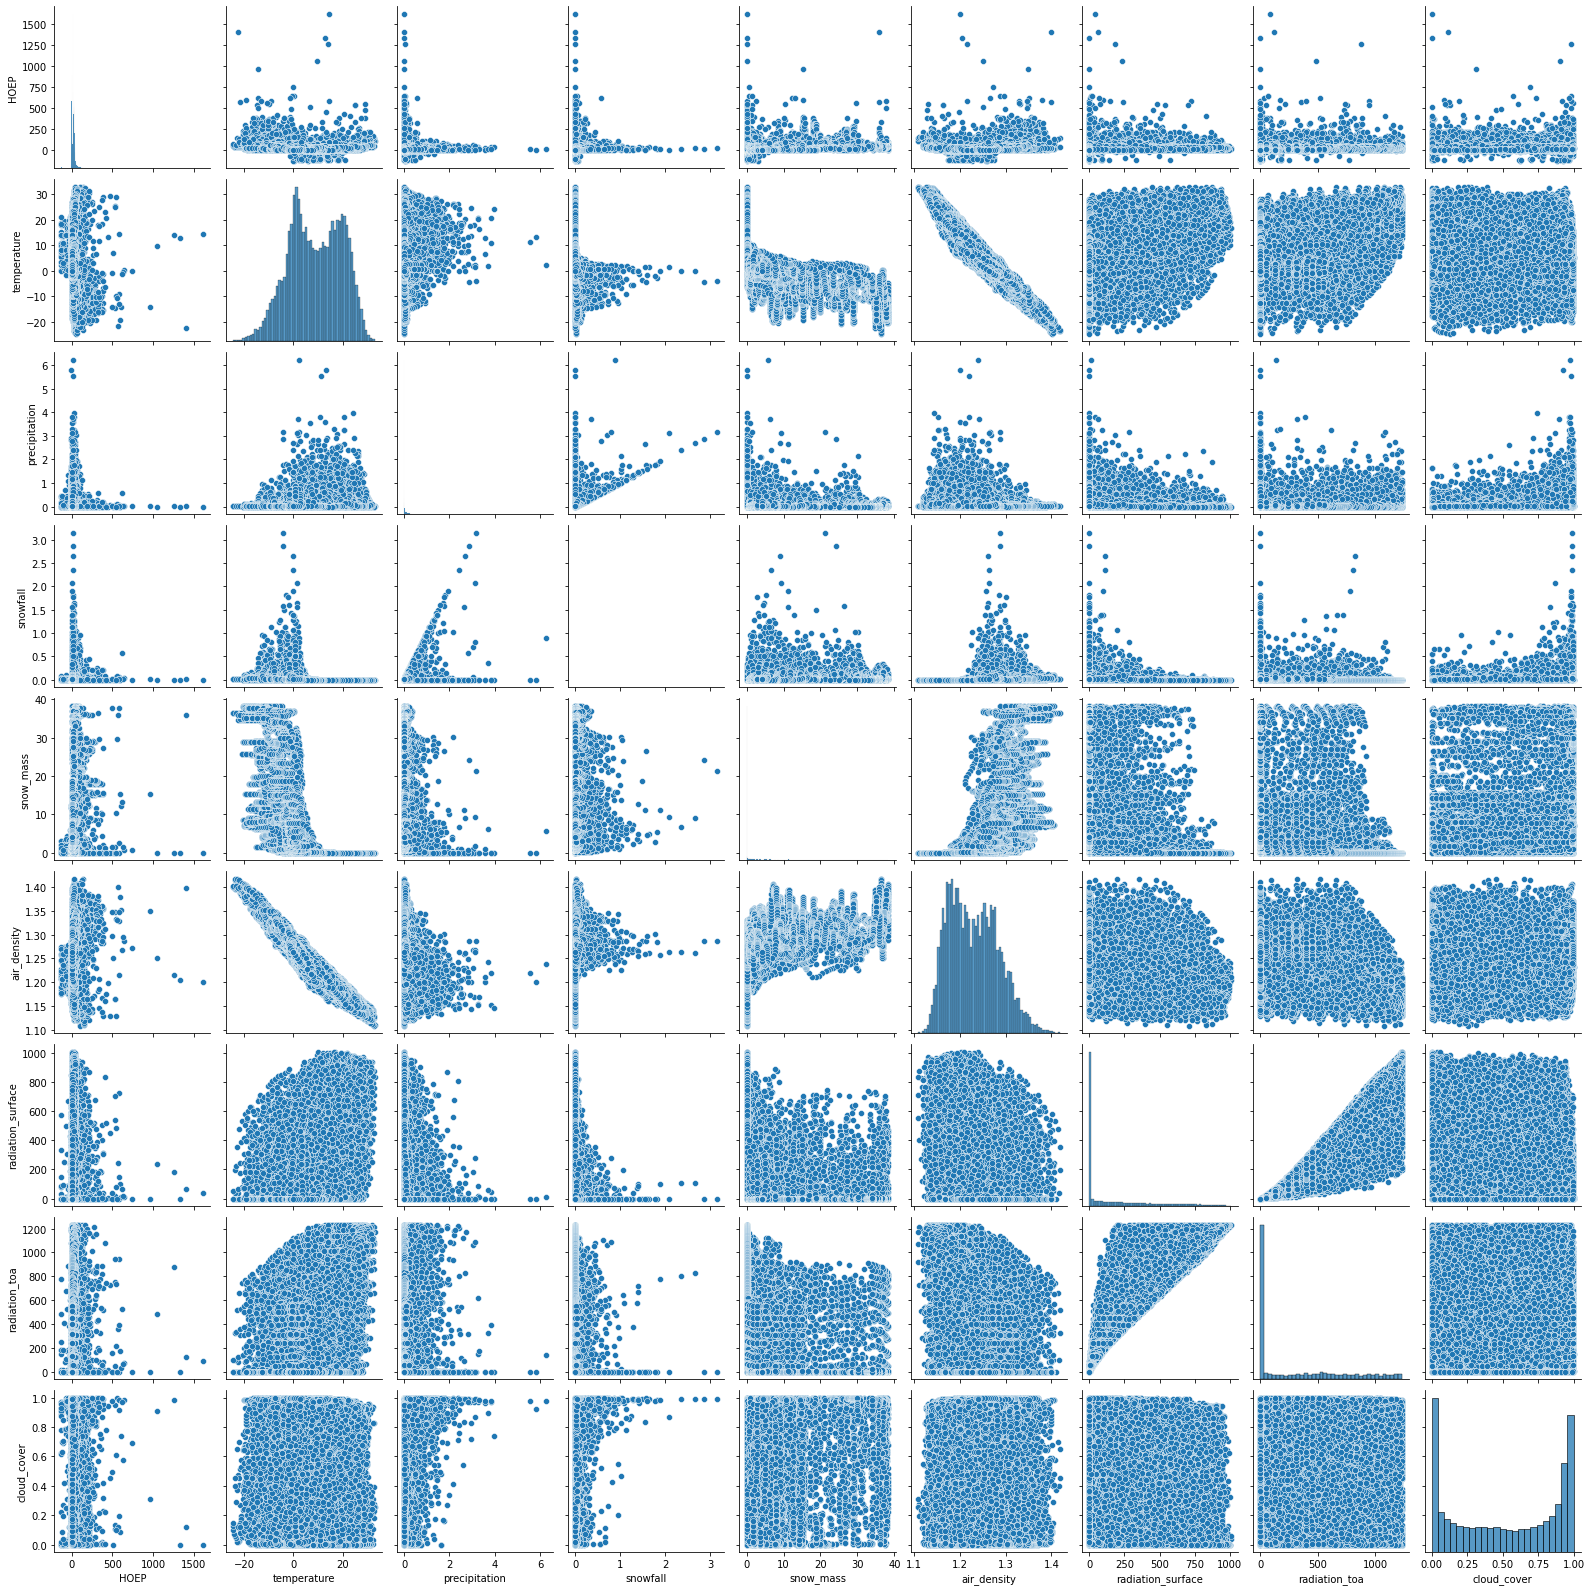

In [35]:
# Produce correlation plots for the variables and
# also with the label
plt.figure()
sns_plot = sns.pairplot(variable_matrix_trn.iloc[:, :-2])
filename="output_linear_models/pairplot.png"
sns_plot.savefig(filename)
if running_in_colab:
  files.download(filename)

We see air density and temperature are highly correlated. For this reason we drop air density and keep only temperature as it is clear both will not benefit the prediction.

In [36]:
# Remove the correlated feature and add temprature^2
variable_matrix_trn = variable_matrix_trn.drop(labels='air_density', axis=1)
variable_matrix_trn.insert(2, 'temperature^2', variable_matrix_trn['temperature']**2)
variable_matrix_trn

,HOEP,temperature,temperature^2,precipitation,snowfall,snow_mass,radiation_surface,radiation_toa,cloud_cover,isWeekend,isHoliday
0,21.71,0.672,0.451584,0.032,0.004,6.048,0.0,0.0,0.538,1,1
1,16.92,0.932,0.868624,0.004,0.002,6.054,0.0,0.0,0.581,1,1
2,11.23,1.319,1.739761,0.006,0.004,6.059,0.0,0.0,0.676,1,1
3,7.10,1.715,2.941225,0.008,0.004,6.066,0.0,0.0,0.624,1,1
4,-6.70,2.019,4.076361,0.013,0.003,6.070,0.0,0.0,0.637,1,1
...,...,...,...,...,...,...,...,...,...,...,...
43843,2.81,2.506,6.280036,0.140,0.014,4.203,0.0,0.0,0.875,1,0
43844,0.00,2.218,4.919524,0.043,0.002,4.131,0.0,0.0,0.579,1,0
43845,0.00,1.579,2.493241,0.017,0.005,4.099,0.0,0.0,0.188,1,0
43846,0.00,0.515,0.265225,0.007,0.003,4.101,0.0,0.0,0.172,1,0


In [37]:
# Do the same thing for variable matrix of all the data
variable_matrix = data.drop(['t', 'Date', 'Hour', 'Datetime', 'Toronto', 'air_density'], axis=1)
variable_matrix.insert(2, 'temperature^2', variable_matrix['temperature']**2)
variable_matrix

,HOEP,temperature,temperature^2,precipitation,snowfall,snow_mass,radiation_surface,radiation_toa,cloud_cover,isWeekend,isHoliday
0,21.71,0.672,0.451584,0.032,0.004,6.048,0.0,0.0,0.538,1,1
1,16.92,0.932,0.868624,0.004,0.002,6.054,0.0,0.0,0.581,1,1
2,11.23,1.319,1.739761,0.006,0.004,6.059,0.0,0.0,0.676,1,1
3,7.10,1.715,2.941225,0.008,0.004,6.066,0.0,0.0,0.624,1,1
4,-6.70,2.019,4.076361,0.013,0.003,6.070,0.0,0.0,0.637,1,1
...,...,...,...,...,...,...,...,...,...,...,...
52603,40.04,-13.263,175.907169,0.004,0.004,16.693,0.0,0.0,0.355,1,0
52604,39.71,-13.505,182.385025,0.004,0.004,16.699,0.0,0.0,0.398,1,0
52605,39.37,-13.618,185.449924,0.004,0.004,16.705,0.0,0.0,0.439,1,0
52606,39.79,-13.762,189.392644,0.005,0.005,16.710,0.0,0.0,0.440,1,0


For the remaining 10 features we apply best subset selection i.e. we find the out-of-sample MSE for each $2^{10}$ possible models and pick the one with the best MSE.

In [38]:
# Creating a list of tuples for feature selection (0 is not selected and 1 is selected)
X = list(itertools.product([0, 1], repeat = len(variable_matrix.columns)))

# Initializing variables we need for the training
tscv = TimeSeriesSplit(n_splits = 10)
y = np.array(data_train.Toronto)

# Creating an empty dataframe where we store the mse scores (usually the lower the mse, the higher the correlation) 
mse_correlation = pd.DataFrame(columns = ['selected columns', 'mse', 'sqrt_mse'])

In [39]:
for tup in X:
    # Based on the tuple of X, select columns evaluated as 1 
    selected_cols = variable_matrix_trn.iloc[:, np.array(tup, dtype = bool)]
    dm = pd.concat([design_matrix_subset_trn, selected_cols], axis = 1)
    lr = LinearRegression()
    # Checking the model's accuracy
    scores = -1 * np.mean(cross_val_score(lr,
                                          dm,
                                          y,
                                          cv=tscv,
                                          scoring='neg_mean_squared_error'))
    # Storing the model's accuracy in dataframe
    mse_correlation = mse_correlation.append({'selected columns': tup,
                                              'mse': scores,
                                              'sqrt_mse': math.sqrt(scores)},
                                              ignore_index=True)

In [40]:
# Show resulting table
mse_correlation

,selected columns,mse,sqrt_mse
0,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",366044.894990,605.016442
1,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)",286456.510639,535.216321
2,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0)",366046.709492,605.017941
3,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1)",286456.636343,535.216439
4,"(0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)",362439.261973,602.029287
...,...,...,...
2043,"(1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1)",154630.230558,393.230506
2044,"(1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0)",215233.803402,463.932973
2045,"(1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1)",154513.217054,393.081693
2046,"(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0)",215241.500776,463.941269


In [41]:
# Find the best subset
min_mse_index_correlation = mse_correlation.iloc[np.argmin(mse_correlation['mse']),:]
min_index = min_mse_index_correlation['selected columns']
min_mse_index_correlation

selected columns    (0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1)
mse                                            153379
sqrt_mse                                      391.636
Name: 879, dtype: object

In [42]:
# Dump log to csv
filename = "output_linear_models/traininglog_bestsubset3.csv"
mse_correlation.to_csv(filename)
if running_in_colab:
  files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

As we see in addition to our seasonal model, best subset selection showed that temperature, temperature^2, snowfall, snow_mass, radiation_toa, cloud_cover, isWeekend and isHoliday were the most important features.

## Regularization
In this section we try to move away from best subset selection and attempt to regularize our full matrix of features i.e. ALL of the fourier bases with ALL of the features by applying ridge regression, lassos regression and elastic net with varying levels of regularization. Our penalty term will have the range $\lambda = \{10^{-2}, 10^{-1}, 1, 10, \dots, 10^5\}$.

In [43]:
# Try a different form of hyp search with regularization, model will no longer be
# interpretable in terms of P_day, P_week and P_year but it will allow to account
# for different combinatons of columns which would be computationally prohibitive
# if we wanted to brute force it i.e. try different possible combinations.

# Merge the features bases with variables
design_matrix_full_trn = pd.concat([design_matrix_trn, variable_matrix_trn], axis=1)
design_matrix_full_trn

# Set up for ridge, lasso and elastic net 
y_train = data_train['Toronto']
folds = TimeSeriesSplit(n_splits=10)
alphas = 10.0**np.arange(-2, 5)

In [44]:
# Ridge regression 
ridge_cv = RidgeCV(alphas=alphas, fit_intercept=True, cv=folds, scoring='neg_mean_squared_error') # Set scoring to MSE
ridge_cv.fit(design_matrix_full_trn, y_train)

RidgeCV(alphas=array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]),
        cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
        scoring='neg_mean_squared_error')

In [45]:
# Get the optimal params, results
ridge_mse = -1*ridge_cv.best_score_
ridge_rmse = np.sqrt(ridge_mse)
ridge_alpha = ridge_cv.alpha_
print(f"Optimal ridge is at alpha={ridge_alpha} with mse={round(ridge_mse, 2)} and rmse={round(ridge_rmse, 2)}")

Optimal ridge is at alpha=100.0 with mse=262456.9 and rmse=512.31


In [46]:
# Lasso Regression
# Suppress the optimization warnings
with warnings.catch_warnings():
  warnings.filterwarnings("ignore")
  lasso_cv = LassoCV(alphas=alphas, fit_intercept=True, cv=folds, verbose=True) # Scoring MSE by default
  lasso_cv.fit(design_matrix_full_trn, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
......................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 29.9min finished


In [47]:
# Get the optimal params, results
lasso_alpha = lasso_cv.alpha_
lasso_mse = lasso_cv.mse_path_.mean(axis=1).min()
lasso_rmse = np.sqrt(lasso_mse)
print(f"Optimal lasso is at alpha={lasso_alpha} with mse={round(lasso_mse, 2)} and rmse={round(lasso_rmse, 2)}")

Optimal lasso is at alpha=10.0 with mse=178012.26 and rmse=421.91


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

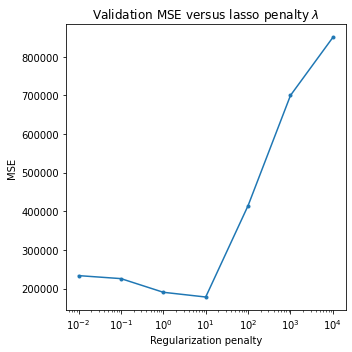

In [48]:
# Plot the validation MSE versus the regularization penalty
mse_penalty = lasso_cv.mse_path_.mean(axis=1)

plt.figure(figsize=(5, 5))
plt.plot(lasso_cv.alphas_, mse_penalty, marker='.')
plt.title("Validation MSE versus lasso penalty $\lambda$")
plt.ylabel("MSE")
plt.xlabel("Regularization penalty")
plt.xscale("log")
plt.tight_layout();
filename = "output_linear_models/lasso.png"
plt.savefig(filename)
if running_in_colab:
  files.download(filename)

The best validation MSE we get is with lasso (which is not surprising because given how many features we have we would want to obtain a sparse selection of features). However, it is unable to beat the best subset selection result.

## Dimensionality reduction 
The other attempt we make at improving our out-of-sample validation score is to start from the full feature matrix and reduce the dimensionality in order to apply a linear model. In a way this is attempting to create a sparse version of our design matrix like in regularization but by explicitly setting the number of components. We train by applying dimensionality reduction with PCA and autoencoders to our full design matrix for a range of compressed dimensions finding the out-of-sample training error for each one.

### Via PCA

In [49]:
# We scale the data to prevent PCA from identifying the most variance solely based on scale
scaler = StandardScaler()
X_scld = scaler.fit_transform(design_matrix_full_trn)

In [50]:
# Range of dimension reduction, try at most 250 dimensions. We try to keep something close to what best subset found
# which was roughly 200 columns.
pca_comp = range(10, 1001, 50)
mse_pca = dict()

In [51]:
# Set up for training
y_train = data_train['Toronto']
folds = TimeSeriesSplit(n_splits=10)

for n_comp in pca_comp:
    pca = PCA(n_components=n_comp)
    X_reduced = pca.fit_transform(X_scld)
    # Create model
    lr = LinearRegression()
    # Checking the model's accuracy
    mse_pca[n_comp] = np.mean(-1*cross_val_score(lr, X_reduced, y_train, cv=folds, scoring='neg_mean_squared_error'))

In [52]:
min_mse = min(mse_pca.values())
min_key = min(mse_pca, key = mse_pca.get)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

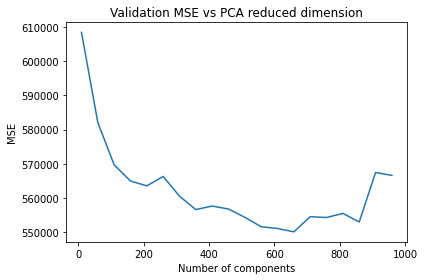

In [53]:
plt.plot(list(mse_pca.keys()), list(mse_pca.values()))
plt.title("Validation MSE vs PCA reduced dimension")
plt.xlabel("Number of components")
plt.ylabel("MSE")
plt.tight_layout();
filename = "output_linear_models/PCA.png"
plt.savefig(filename)
if running_in_colab:
  files.download(filename)

In [54]:
print(f"The minimum mse/rmse are {round(min_mse, 2)} and {round(math.sqrt(min_mse), 2)} corresponding to a dimension of {min_key}")

The minimum mse/rmse are 550117.83 and 741.7 corresponding to a dimension of 660


Dimensionality reduction with PCA does not provide a significant improvement with respect to the optimal number of features we found with best subset selection (180 dimensions). Although the validation MSE trend is decreasing this is expected since we are just giving the model more features to work with.

### Via autoencoders
We attempt to reduce the dimensionality of the dataset via autoencoders. Because we already know that most of the yearly $\sin, \cos$ terms are not important for model prediction we use the compressed matrix version. The steps essentially involve training an autoencoder to reduce the dimensionality and then using the reduced number of features for a linear model. The following [source](https://medium.com/@vaibhaw.vipul/building-autoencoder-in-pytorch-34052d1d280c) was used as a reference to build the autoencoder class.

In [55]:
# We would like to create an autoencoder that optimally summarizes our full matrix
# However the number of paramters that result from this is far too large
# We instead use our no_overflow matrix making sure to use on the training set data
design_matrix_no_overflow_full = pd.concat([design_matrix_no_overflow[:train_val_split], variable_matrix_trn], axis=1)
scaler = StandardScaler()
X_scld = scaler.fit_transform(design_matrix_no_overflow_full)

In [56]:
# You need to reference this code
# Create an autoencoder
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_dim, first_layer_dim, second_layer_dim, hidden_compression, output_dim): 
        super(AutoEncoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_compression = hidden_compression
        self.output_dim = output_dim
        self.first_layer_dim = first_layer_dim
        self.second_layer_dim = second_layer_dim
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, first_layer_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(first_layer_dim, second_layer_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(second_layer_dim, hidden_compression)
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(hidden_compression, second_layer_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(second_layer_dim, first_layer_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(first_layer_dim, output_dim)
        )
    
    def forward(self, X):
        X_enc = self.encoder(X)
        X_dec = self.decoder(X_enc)
        return X_dec

In [57]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [58]:
# Train the model
torch.manual_seed(0)
# Use a similar compression range as the PCA but restrict further due to the trainig overhead
ae_comp = range(50, 501, 50)
mse_ae = dict()
X_torch = torch.tensor(X_scld).type(torch.float32)
# For each compression range train the network and then find validation MSE
for hidden_comp in ae_comp:
    # Set the model
    input_dim = output_dim = X_torch.shape[1]
    first_layer_dim = 1000
    second_layer_dim = 750
    model = AutoEncoder(input_dim, first_layer_dim, second_layer_dim, hidden_comp, output_dim)
    loss = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # Set the training parameters
    num_epochs = 500 # High number of epochs because the AE were taking long to train
    batch_size = 500 # Do not tune the batch size only number of latent dimensions
    for epoch in range(num_epochs):
      X_trn = X_torch
      X_reconstruct = model(X_trn)
      l = loss(X_reconstruct, X_trn) # in this case y_true is the uncompressed training data
      model.zero_grad()
      l.backward()
      optimizer.step()
      if epoch == num_epochs-1:
        print(f"Final training loss is {l}")
    # Use the model to compress design_matrix for the linear model
    with torch.no_grad():
        # Only want to encode now, "throw out" the decoder
        X_compressed = model.encoder(X_torch)
        # Create model
        lr = LinearRegression()
        # Checking the model's accuracy
        mse_ae[hidden_comp] = np.mean(-1*cross_val_score(lr, X_compressed, y_train, cv=folds, scoring='neg_mean_squared_error'))
    
    print(f"Finished component decomposition {hidden_comp}")
        

Final training loss is 0.47243210673332214
Finished component decomposition 50
Final training loss is 0.45246514678001404
Finished component decomposition 100
Final training loss is 0.46021994948387146
Finished component decomposition 150
Final training loss is 0.4429410398006439
Finished component decomposition 200
Final training loss is 0.45049941539764404
Finished component decomposition 250
Final training loss is 0.453319787979126
Finished component decomposition 300
Final training loss is 0.44254568219184875
Finished component decomposition 350
Final training loss is 0.4428815543651581
Finished component decomposition 400
Final training loss is 0.440095990896225
Finished component decomposition 450
Final training loss is 0.452755331993103
Finished component decomposition 500


In [59]:
# Get the minimum out-of-sample validation error and the 
# corresponding compression size
min_mse = min(mse_ae.values())
min_key = min(mse_ae, key = mse_ae.get)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

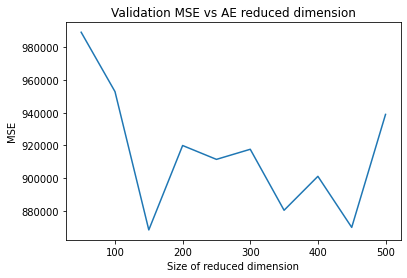

In [60]:
# Plot the validation mse versus AE reduced dimension
plt.plot(list(mse_ae.keys()), list(mse_ae.values()))
plt.title("Validation MSE vs AE reduced dimension")
plt.xlabel("Size of reduced dimension")
plt.ylabel("MSE");
filname = "output_linear_models/AutoEncoders.png";
plt.savefig(filename)
if running_in_colab:
  files.download(filename)

In [61]:
print(f"The minimum mse/rmse are {round(min_mse, 2)} and {round(math.sqrt(min_mse), 2)} corresponding to a dimension of {min_key}")

The minimum mse/rmse are 868476.94 and 931.92 corresponding to a dimension of 150


We again see that reducing the dimensionality does not provide better results that the original optimal dimensionality that was brute forced through best subset selection. As a result we can conclude that reduce the dimension directly will not provide for improved regression results.

## Arima Errors
We retrain our model but this time look at the residual errors for the whole training set and attempt to model these with an ARIMA model. We use the best model we have observed so far which in this case was found from the best subset selection, calculate the training error and train an ARIMA model on it. This is a form of stacking. <br> 
If we have $y = \hat{y} + \epsilon \Rightarrow y - \hat{y} = \epsilon$.<br>
If we can then estimate $\epsilon = \hat{\epsilon} + \delta$ then we would have that $y = \hat{y} + \hat{\epsilon} + \delta$.

In [62]:
variable_matrix_trn
min_mse_index_correlation

selected columns    (0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1)
mse                                            153379
sqrt_mse                                      391.636
Name: 879, dtype: object

In [63]:
variable_subset_best = variable_matrix_trn.iloc[:, np.array(min_index, dtype=bool)]
design_matrix_best = pd.concat([design_matrix_subset_trn, variable_subset_best], axis=1)

In [64]:
# Re-train the linear model on the whole training data
lm_best = LinearRegression()
lm_best.fit(design_matrix_best, y_train)

LinearRegression()

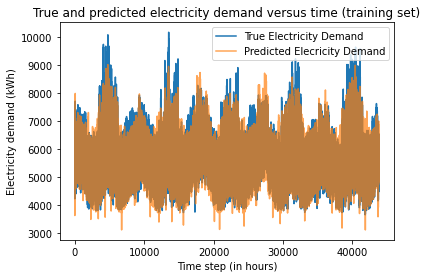

In [65]:
# Get plots for true and trained for the training set, this will get messy
y_pred = lm_best.predict(design_matrix_best)
y_true = data_train['Toronto']
time_index = data_train['t']

plt.plot(time_index, y_true, label="True Electricity Demand")
plt.plot(y_pred, alpha=0.7, label="Predicted Elecricity Demand")
plt.title("True and predicted electricity demand versus time (training set)")
plt.ylabel("Electricity demand (kWh)")
plt.xlabel("Time step (in hours)")
plt.legend();

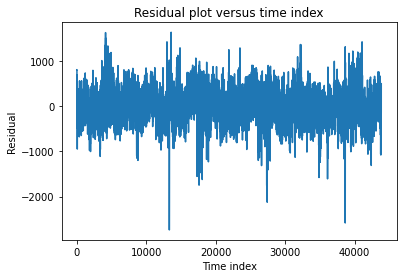

In [66]:
# Get the residual plot
residual = y_true - y_pred
plt.plot(data_train['t'], residual)
plt.title("Residual plot versus time index")
plt.ylabel("Residual")
plt.xlabel("Time index");

We try to see if we can use an ARIMA [see source](https://otexts.com/fpp2/regarima.html) to model the regression error. We will not re-explain the workings of the time series training here, please see the time series notebook for that. We also bring some of the helper functions used in that notebook for the cross-validation.

In [67]:
def rolling_window_time_series(model, n_splits, X, y):
    '''
    Returns the mse and rmse of the 'rolling window' cross validation

            Parameters:
                    model : A time series model
                    n_splits (int): Number of splits to perform
                    X (Series): The time series on which to train
                    y (Series): The time series on which to predict. May be the
                    same as X.

            Returns:
                     mse_cv (float), rmse_cv (float): Validation mse and rmse
    '''
    # Keep a running total of the mean mse
    mse_cv = 0
    N = 1
    ts_splitter = sklearn.model_selection.TimeSeriesSplit(n_splits=n_splits)
    for train, valid in ts_splitter.split(X):
        # For each train, valid fold fit it on train
        model.fit(X[train], y[train])
        # Predict on valid
        y_pred = model.predict(X[valid])
        # Find mse of this fold and then add it to the running average
        mse_fold = sklearn.metrics.mean_squared_error(y_true=y[valid], y_pred=y_pred)
        # This is to keep a running average (instead of appending to an array 
        # and then taking the mean)
        if N == 1:
            mse_cv = mse_fold
        else:
            # This can be checked by expanding the formula for the mean
            mse_cv += (mse_fold - mse_cv)/N
        N+=1
    # Return mse and rmse
    return mse_cv, math.sqrt(mse_cv)


In [68]:
# Will need a wrapper class for the ts models to act like sklearn fit(X, y) and predict(X)
class TimeSeriesWrapper:
    """
    A class to wrap the statsmodel models so that we can call fit and predict.

    ...

    Attributes
    ----------
    model : 
      The statsmodel model to wrap.
    kwargs :
      Set of keyword arguments used for the statsmodel instance call.

    Methods
    ----------
    fit(X, y=None):
      Fits X to the model.
    predict(X):
      Predict the value for X.
    """

    def __init__(self, model, **kwargs):
      """
      Construct attributes for wrapper instance.

      Parameters
      ----------
      model : 
        Statsmodel model to wrap.
      kwargs:
        Key word arguments used for the model.
      """
      self.model = model
      self.kwargs = kwargs

    def fit(self, X, y=None):
      """
      Fit the model using the statsmodel syntax by passing X and kwargs and 
      then calling fit.

      Parameters
      ----------
      X : Series
        We expect this to be a series object
      y : 
        The y value is not used but necessary for the use of the cross-valid
        function.

      Returns
      -------
      None
      """
      # Suppress any convergence warnings
      with warnings.catch_warnings():
          warnings.filterwarnings("ignore")
          self.model_fit = self.model(X, **self.kwargs).fit()
        
    def predict(self, X):
      """
      Predict for values of X using the statsmodel pridct syntax.

      Parameters
      ----------
      X : Series
        We expect this to be a series object that we want to predict

      Returns
      -------
      y_pred : 
        The predicted values for X.
      """
      return self.model_fit.predict(X.index[0], X.index[-1])

In [69]:
# Create a series object 
ts_residual = pd.Series(data=residual)

In [70]:
# Consider the set of possible models
p_max, d_max, q_max = 2, 1, 2
p_arr = np.array(range(p_max+1), dtype=np.int32)
d_arr = np.array(range(d_max+1), dtype=np.int32)
q_arr = np.array(range(q_max+1), dtype=np.int32)
p_grid, d_grid, q_grid = np.meshgrid(p_arr, d_arr, q_arr, indexing='ij')
hyperparam_arr = np.column_stack([p_grid.ravel(), d_grid.ravel(), q_grid.ravel()])
rmse_grid = np.empty_like(p_grid)
mse_grid = np.empty_like(p_grid)

In [71]:
# Train for each hyperparameter
for p, d, q in hyperparam_arr:
    n_splits = 10
    model_arima = TimeSeriesWrapper(ARIMA, order=(p, d, q))
    mse_grid[p, d, q], rmse_grid[p, d, q] = rolling_window_time_series(model_arima,
                                                                          n_splits,
                                                                          ts_residual,
                                                                          ts_residual)
    print(f"Finished ARIMA({p}, {d}, {q})")

Finished ARIMA(0, 0, 0)
Finished ARIMA(0, 0, 1)
Finished ARIMA(0, 0, 2)
Finished ARIMA(0, 1, 0)
Finished ARIMA(0, 1, 1)
Finished ARIMA(0, 1, 2)
Finished ARIMA(1, 0, 0)
Finished ARIMA(1, 0, 1)
Finished ARIMA(1, 0, 2)
Finished ARIMA(1, 1, 0)
Finished ARIMA(1, 1, 1)
Finished ARIMA(1, 1, 2)
Finished ARIMA(2, 0, 0)
Finished ARIMA(2, 0, 1)
Finished ARIMA(2, 0, 2)
Finished ARIMA(2, 1, 0)
Finished ARIMA(2, 1, 1)
Finished ARIMA(2, 1, 2)


In [72]:
# Provide results
for p, d, q in hyperparam_arr:
    print(f"ARIMA({p},{d},{q}) validation mse = {round(mse_grid[p, d, q], 2)} and "
          f"rmse = {round(rmse_grid[p, d, q], 2)}")

ARIMA(0,0,0) validation mse = 121815 and rmse = 349
ARIMA(0,0,1) validation mse = 121796 and rmse = 348
ARIMA(0,0,2) validation mse = 121781 and rmse = 348
ARIMA(0,1,0) validation mse = 231941 and rmse = 481
ARIMA(0,1,1) validation mse = 231634 and rmse = 481
ARIMA(0,1,2) validation mse = 231918 and rmse = 481
ARIMA(1,0,0) validation mse = 121545 and rmse = 348
ARIMA(1,0,1) validation mse = 121596 and rmse = 348
ARIMA(1,0,2) validation mse = 121612 and rmse = 348
ARIMA(1,1,0) validation mse = 236098 and rmse = 485
ARIMA(1,1,1) validation mse = 231789 and rmse = 481
ARIMA(1,1,2) validation mse = 149400 and rmse = 386
ARIMA(2,0,0) validation mse = 121638 and rmse = 348
ARIMA(2,0,1) validation mse = 121608 and rmse = 348
ARIMA(2,0,2) validation mse = 121600 and rmse = 348
ARIMA(2,1,0) validation mse = 228877 and rmse = 478
ARIMA(2,1,1) validation mse = 229042 and rmse = 478
ARIMA(2,1,2) validation mse = 230719 and rmse = 480


In [73]:
# Best ARIMA order
best_order = np.unravel_index(np.argmin(mse_grid, axis=None), mse_grid.shape)
best_order

(1, 0, 0)

We see that the rmse for the best ARIMA model on the residuals is about 350. In other words it helps the model better predict electricity demand by about 40 kWh (since the optimal rmse had validation rmse around 500). Although this is not tremendous it is useful nonetheless.

We provide plots of the prediction of the best design matrix with and without ARIMA errors for the first half of 2017.

In [74]:
# Create the validation design matrix
variable_subset_best = variable_matrix.iloc[train_val_split:, np.array(min_index, dtype=bool)]
design_matrix_val = pd.concat([design_matrix_subset[train_val_split:], variable_subset_best], axis=1)

In [75]:
# Check that the training design matrix and validation design matrix have same number of columns
# Just different number of rows
print(design_matrix_best.shape)
print(design_matrix_val.shape)

(43848, 176)
(8760, 176)


In [76]:
# Predict for first half of 2017
val_size = 365*12
y_pred = lm_best.predict(design_matrix_val)[:val_size]

In [77]:
# Plot the whole prediction and a specific week (the same as the one from time series)
# Get the specific week
week_start = 8*(7*24)
week_end = 9*(7*24)
# This corresponds to the following dates
date_start = data.loc[train_val_split+week_start, 'Datetime']
date_end = data.loc[train_val_split+week_end-1, 'Datetime'] # Hour before
print(date_start)
print(date_end)

2017-02-26 00:00:00
2017-03-04 23:00:00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

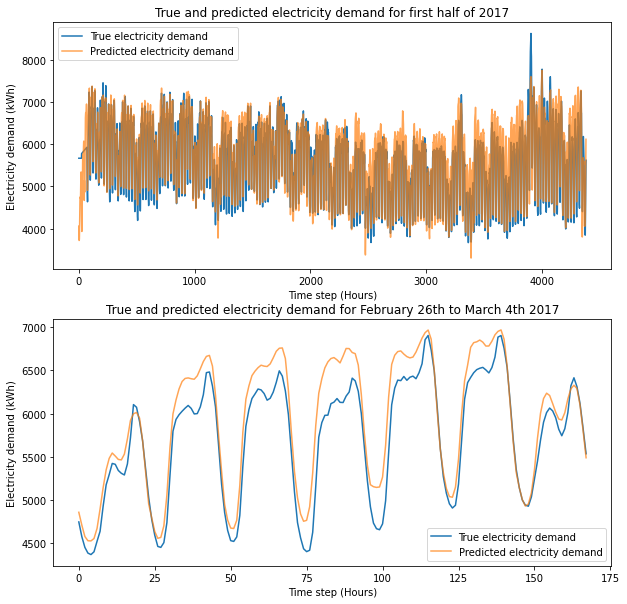

In [78]:
# Plot for half a year and a week
y_true = data.loc[train_val_split:train_val_split+val_size, 'Toronto']
y_true = y_true.to_numpy()
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(y_true, label="True electricity demand")
plt.plot(y_pred, alpha=0.7, label="Predicted electricity demand")
plt.title("True and predicted electricity demand for first half of 2017")
plt.xlabel("Time step (Hours)")
plt.ylabel("Electricity demand (kWh)")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(y_true[week_start:week_end], label="True electricity demand")
plt.plot(y_pred[week_start:week_end], alpha=0.7, label="Predicted electricity demand")
plt.title("True and predicted electricity demand for February 26th to March 4th 2017")
plt.xlabel("Time step (Hours)")
plt.ylabel("Electricity demand (kWh)")
plt.legend()

plt.tight_layout;
filename = path + "/linear_models_pred1.png"
plt.savefig(filename)
if running_in_colab:
  files.download(filename)

In [79]:
# Retrain the arima over the whole training set with the best order
arima_best = TimeSeriesWrapper(ARIMA, order=best_order)
arima_best.fit(ts_residual)
residual_pred = arima_best.predict(data[train_val_split:train_val_split+val_size])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

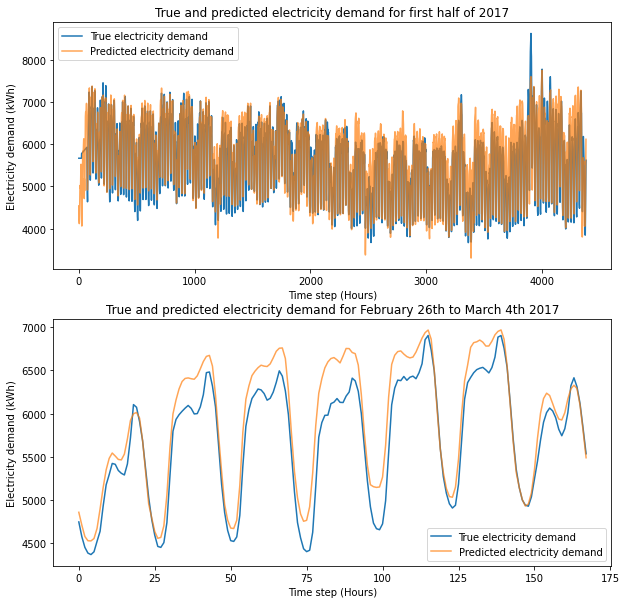

In [80]:
# Plot residual prediction from the ARIMA + the linear model prediction
y_pred = y_pred + residual_pred
y_pred = y_pred.to_numpy()
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(y_true, label="True electricity demand")
plt.plot(y_pred, alpha=0.7, label="Predicted electricity demand")
plt.title("True and predicted electricity demand for first half of 2017")
plt.xlabel("Time step (Hours)")
plt.ylabel("Electricity demand (kWh)")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(y_true[week_start:week_end], label="True electricity demand")
plt.plot(y_pred[week_start:week_end], alpha=0.7, label="Predicted electricity demand")
plt.title("True and predicted electricity demand for February 26th to March 4th 2017")
plt.xlabel("Time step (Hours)")
plt.ylabel("Electricity demand (kWh)")
plt.legend()

plt.tight_layout;
filename = path + "/linear_models_pred2.png"
plt.savefig(filename)
if running_in_colab:
  files.download(filename)

The ARIMA fits the training very well which doesn't tell us very much, but nonetheless after all these experiments it appears that the Fourier best subset regression with ARIMA error provide the best out-of-sample validation score. 

In [81]:
# We export the full design matrix to evaluate it on the test set
variable_subset_best = variable_matrix.iloc[:, np.array(min_index, dtype=bool)]
design_matrix = pd.concat([design_matrix_subset, variable_subset_best], axis=1)
design_matrix.to_csv('best_design_matrix.csv')
